In [1]:
import torch
%matplotlib inline

import os
import gzip
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
#from scipy import ndimage

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output
from datetime import datetime
from torchvision import datasets, transforms

from PIL import Image
from IPython.display import Image 



In [2]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

print(dev)

cuda:0


In [3]:
batch_size = 10

In [4]:
from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image
import re


px_size = 60
py_size = 60

class DatasetMSE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.colour = torch.stack([self.get_colour(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/00*')]).to(dev)
        self.input_imgs = torch.stack([(self.tf((Image.open(file)))) for file in glob.glob(image_dir + '/00*')]).to(dev)
        self.add_colour()

    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    def get_labels(self, x):
        new_x = torch.zeros(6,px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[self.col_sim(new_d3[i][j])][i][j] = 1
                
        return new_x
        
    def get_colour(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
        
    def add_colour(self):
        print(self.input_imgs.shape)
        for i in range(self.input_imgs.shape[0]):
            print(i)
            self.input_imgs[i][0][self.colour[i] == 3] += 0.2
            self.input_imgs[i][1][self.colour[i] == 4] += 0.2
            self.input_imgs[i][2][self.colour[i] == 5] += 0.2
        self.input_imgs = self.input_imgs.clamp(0, 1)
            #new_x[1][y[i]==4] += 0.5
            #new_x[2][y[i]==5] += 0.5
            #new_x[2][y[i] == 0] += 0.5
            #new_x[1][y[i]==0] += 0.5
        
    
    def print_tensor(self, x):
        print(self.input_imgs[x])

In [32]:
dset_mse = DatasetMSE("Original","Labeled")
train_loader_MSE = torch.utils.data.DataLoader(dset_mse, shuffle=True, batch_size=batch_size)
#dset_mse.print_tensor(2)

torch.Size([9, 3, 60, 60])
0
1
2
3
4
5
6
7
8


In [3]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [11]:
def initial_seed(batch_size):
    return torch.zeros(batch_size, 3, px_size, py_size)

# Encode colour classes 1
def to_classes(d):
    d = d*255
    x = torch.zeros(6, d.shape[1], d.shape[2])
    # RED 255,0,0
    x[0][(d[0] > 220) & (d[1] < 20) & (d[2] < 20)] = 1
    # BROWN 127,0,0
    x[1][(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[2][(d[0] > 20) & (d[1] > 30) & (d[2] < 230)] = 1
    # LIGHT BLUE 0,255,255
    x[3][(d[0] < 100) & (d[1] > 100) & (d[2] > 100)] = 1
    # DARK BLUE 0,0,255
    x[4][(d[0] < 30) & (d[1] < 30) & (d[2] > 150)] = 1
    # GREEN 0,255,0
    x[5][(d[0] < 120) & (d[1] > 140) & (d[2] < 160)] = 1
    return torch.FloatTensor(x)

# Encode colour classes 2
def to_class(d):
    d = d*255
    x = torch.zeros(d.shape[1], d.shape[2])
    # RED 255,0,0
    #x[(d[0] > 180) & (d[1] < 60) & (d[2] < 60)] = 0
    # BROWN 127,0,0
    x[(d[0] > 60) & (d[0] < 200) & (d[1] < 60) & (d[2] < 60)] = 1
    # YELLOW 255, 255, 0
    x[(d[0] > 100) & (d[1] > 100) & (d[2] < 100)] = 2
    # LIGHT BLUE 0,255,255
    x[(d[0] < 60) & (d[1] > 180) & (d[2] > 180)] = 3
    # DARK BLUE 0,0,255
    x[(d[0] < 60) & (d[1] < 60) & (d[2] > 180)] = 4
    # GREEN 0,255,0
    x[(d[0] < 70) & (d[1] > 170) & (d[2] < 70)] = 5
    return torch.FloatTensor(x)

colors = {
    0:torch.FloatTensor([255.0, 0.0, 0.0]).to(dev),
    1:torch.FloatTensor([127.0, 0.0, 0.0]).to(dev),
    2:torch.FloatTensor([255.0, 255.0, 0.0]).to(dev),
    3:torch.FloatTensor([0.0, 255.0, 255.0]).to(dev),
    4:torch.FloatTensor([0.0, 0.0, 255.0]).to(dev),
    5:torch.FloatTensor([0.0, 255.0, 0.0]).to(dev)
    }
          
    
# Get RGB class channels
def get_rgb(x):
    return x.transpose(0,1)[3:9].transpose(0,1)

# Transform to display image
ts = transforms.ToPILImage()

# Get max class value and convert to RGB for the C classes
def max_rgb(x):
    newimg = torch.zeros(x.shape[0], px_size, px_size, 3).to(dev)
    for i in range(x.shape[0]):
        # RED 255, 0, 0
        newimg[i][torch.argmax(x[i],dim=0) == 0] = colors[0]
        # BROWN 127 0 0 
        newimg[i][torch.argmax(x[i],dim=0) == 1] = colors[1]
        # YELLOW 255, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 2] = colors[2]
        # L BLUE 0, 255, 255
        newimg[i][torch.argmax(x[i],dim=0) == 3] = colors[3]
        # D BLUE 0, 0, 255
        newimg[i][torch.argmax(x[i],dim=0) == 4] = colors[4]
        # GREEN 0, 255, 0
        newimg[i][torch.argmax(x[i],dim=0) == 5] = colors[5]
    
    return (newimg/255.0).transpose(1,3).transpose(2,3)


def max_rgba(x):
    newimg = torch.zeros(px_size, px_size, 3)
    # RED 255, 0, 0
    newimg[torch.argmax(x,dim=0) == 0] = torch.FloatTensor([255.0, 0.0, 0.0])
    # BROWN 127 0 0 
    newimg[torch.argmax(x,dim=0) == 1] = torch.FloatTensor([127.0, 0.0, 0.0])
    # YELLOW 255, 255, 0
    newimg[torch.argmax(x,dim=0) == 2] = torch.FloatTensor([255.0, 255.0, 0.0])
    # L BLUE 0, 255, 255
    newimg[torch.argmax(x,dim=0) == 3] = torch.FloatTensor([0.0, 255.0, 255.0])
    # D BLUE 0, 0, 255
    newimg[torch.argmax(x,dim=0) == 4] = torch.FloatTensor([0.0, 0.0, 255.0])
    # GREEN 0, 255, 0
    newimg[torch.argmax(x,dim=0) == 5] = torch.FloatTensor([0.0, 255.0, 0.0])
    
    alpha = torch.max(x, dim=0).values.to(dev)
    #alpha = alpha/torch.max(alpha)
    newimg = (newimg/255.0).to(dev)
    newimg = torch.cat((newimg, alpha.view(px_size, px_size, 1)), dim=2)
    print(newimg.shape)
    return newimg.transpose(0,2).transpose(1,2)

# Flatten dimension
def loss_classes(x):
    y = torch.flatten(x,1,2)
    return y


In [ ]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, labels = next(iter(train_loader_CE))
# Make a grid from batch
out = torchvision.utils.make_grid(torch.cat((inputs, max_rgb(labels)),dim=0), nrow=batch_size)
imshow(out, title="Sample Batch (Image and Ground Truth)")


In [4]:
batch_size = 10

In [5]:
# Cross Entropy

from torch.utils.data import Dataset, DataLoader
import os
import glob
from PIL import Image


px_size = 60
py_size = 60

class DatasetCE(Dataset):

    def __init__(self, image_dir, label_dir):
        self.colors = {
            0:torch.FloatTensor([255.0, 0.0, 0.0]),
            1:torch.FloatTensor([127.0, 0.0, 0.0]),
            2:torch.FloatTensor([255.0, 255.0, 0.0]),
            3:torch.FloatTensor([0.0, 255.0, 255.0]),
            4:torch.FloatTensor([0.0, 0.0, 255.0]),
            5:torch.FloatTensor([0.0, 255.0, 0.0])
            }
        
        self.transforms = []
        self.tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((px_size,py_size))])
        self.input_imgs = torch.stack([self.tf((Image.open(file))) for file in glob.glob(image_dir + '/*')]).to(dev)
        self.label_imgs = torch.stack([self.get_labels(self.tf((Image.open(file)))) for file in glob.glob(label_dir + '/*')]).to(dev)
        #self.add_colour()
    
    def __len__(self):
        return len(self.input_imgs)


    def __getitem__(self, idx):
        input_img, label_img = self.input_imgs[idx], self.label_imgs[idx]
        return input_img, label_img
    
    def col_sim(self, d):
        d = d*255
        a = torch.FloatTensor([torch.dist(d, self.colors[i]) for i in self.colors])
        return torch.argmin(a) 
    
    def view_shape(self):
        print(self.label_imgs.shape)
        print(self.input_imgs.shape)
    
    # (3, x, y)
    def get_labels(self, x):
        new_x = torch.zeros(px_size,px_size)
        for i in range(px_size):
            for j in range(px_size):
                new_d3 = x.transpose(0,1).transpose(1,2)
                new_x[i][j] = self.col_sim(new_d3[i][j])
        return new_x
    
    def add_colour(self):
        y = self.label_imgs.clone().detach()
        for i in range(self.input_imgs.shape[0]):
            self.input_imgs[i][0][y[i] == 3] += 0.3
            self.input_imgs[i][1][y[i] == 4] += 0.3
            self.input_imgs[i][2][y[i] == 5] += 0.3
        self.input_imgs = self.input_imgs.clamp(0, 1)

    

    

In [6]:
# Cross Entropy

dsetCE = DatasetCE("Original","Labeled")
train_loader_CE = torch.utils.data.DataLoader(dsetCE, shuffle=True, batch_size=batch_size)
dsetCE.__len__()

150

In [7]:
train_DS, test_DS = torch.utils.data.random_split(dsetCE, [120, 30])
train_loader_CE = torch.utils.data.DataLoader(train_DS, shuffle=True, batch_size=batch_size)
test_loader_CE = torch.utils.data.DataLoader(test_DS, shuffle=True, batch_size=1)

In [16]:
# Cellular automata class
class CAModel(nn.Module):

    def __init__(self, channel_n, fire_rate=0.5, device=torch.device("cpu")):
        super(CAModel, self).__init__()

        self.device = device
        self.channel_n = channel_n        

        self.fire_rate = fire_rate
        self.to(self.device)
        
        self.conv0 = nn.Conv2d(45, 1, kernel_size=px_size)
        self.conv1 = nn.Conv2d(46, 34, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(34, 16, kernel_size=1)
        self.conv3 = nn.Conv2d(16, 6, kernel_size=1)
        
        self.prewitt_x = torch.FloatTensor([[1,0,-1],[1,0,-1],[1,0,-1]]).to(dev)
        self.prewitt_y = torch.FloatTensor([[1,1,1],[0,0,0],[-1,-1,-1]]).to(dev)
        
        self.sobel_x = torch.FloatTensor([[1,0,-1],[2,0,-2],[1,0,-1]]).to(dev)
        self.sobel_y = torch.FloatTensor([[1,2,1],[0,0,0],[-1,-2,-1]]).to(dev)
        
    def perceive(self, x, angle):

        def _perceive_with(x, weight):
            size = weight.shape[0]
            padding = (size-1)/2
            weight = weight.view(1,1,size,size).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, weight, padding=int(padding), groups=self.channel_n)
        
        # 3x3 sobel operators
        wa_1 = self.sobel_x
        wa_2 = self.sobel_y
        wa_3 = self.prewitt_x
        wa_4 = self.prewitt_y
        
        # Normalise these
        wa_1/=torch.sum(torch.abs(wa_1))
        wa_2/=torch.sum(torch.abs(wa_2))
        wa_3/=torch.sum(torch.abs(wa_3))
        wa_4/=torch.sum(torch.abs(wa_4))

        # Apply convolutions with the 4 of these filters
        y1 = _perceive_with(x, wa_1)
        y2 = _perceive_with(x, wa_2)
        y3 = _perceive_with(x, wa_1)
        y4 = _perceive_with(x, wa_2)

        # Concatenate: x (6 channels), 4 sobel filters (6 channels each), max pool (6 channels) = 36 total
        y = torch.cat((x,y1,y2,y3,y4),1)
        return y
    
    def forward(self, steps, x, last=False):
        x = torch.cat((x, torch.zeros(batch_size,6,px_size,px_size).to(dev)), dim=1)
        if last == True:
            epoch_history = []
            for i in range(steps):
                epoch_history.append(x.detach().transpose(0,1)[3:9])
                b0 = self.perceive(x, 0)
                b1 = self.conv0(b0)
                b10 = torch.zeros(batch_size, 1, px_size, px_size).to(dev) + b1
                b2 = torch.cat((b0, b10), dim=1)
                b3 = self.conv3((self.conv2(self.relu(self.conv1(b2)))))

                c = x.detach().clone()
                stochastic = torch.rand([b3.size(0),b3.size(1),b3.size(2),b3.size(3)])>self.fire_rate
                stochastic = stochastic.float().to(self.device)

                d = b3*stochastic
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
                
            return x, epoch_history
                
        else:
            for i in range(steps):
                b0 = self.perceive(x, 0)
                b1 = self.conv0(b0)
                b10 = torch.zeros(batch_size, 1, px_size, px_size).to(dev) + b1
                b2 = torch.cat((b0, b10), dim=1)
                b3 = self.conv3((self.conv2(self.relu(self.conv1(b2)))))

                c = x.detach().clone()
                stochastic = torch.rand([b3.size(0),b3.size(1),b3.size(2),b3.size(3)])>self.fire_rate
                stochastic = stochastic.float().to(self.device)

                d = b3*stochastic
                e = c.transpose(0,1)[3:9].transpose(0,1) + d
                f = F.softmax(e, dim=1)
                
                x = torch.cat((c.transpose(0,1)[0:3].transpose(0,1),f),dim=1)
            return x

In [17]:
# Load model, set loss function, optimizer and scheduler

model = CAModel(9,fire_rate=0.5,device=dev)
#model = torch.load('modelcollab1.pth')
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.999)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [30,60,90], 0.6)
#loss1 = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')

# RED, BROWN, YELLOW, LBLUE, DBLUE, GREEN
w = torch.FloatTensor([2,1, 1.05, 8.9, 9, 8.8]).to(dev)
loss2 = torch.nn.CrossEntropyLoss(weight=w, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
#loss = torch.nn.KLDivLoss(size_average=None, reduce=None, reduction='mean', log_target=False)
#loss = FocalLoss()
loss_mse = []
loss_ce = []
history = []
epochs = 250

batch_size=10

In [ ]:
for epoch in range(epochs):
    i = 0
    last = False
    if epoch == epochs-1:
        last = True
    for batch in train_loader_MSE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)
            
        b = get_rgb(x)
        out = loss1(b,targets)
        print("Loss =", out)
        loss_mse.append(float(out))
        c = b.detach().clone()
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            del c
            
        i += 1
        optimizer.zero_grad()
        out.backward()
        optimizer.step()

In [19]:
torch.save(model, 'modelMSE.pth')

Loss = tensor(1.7913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


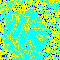

Learning rate:  0.001
Loss = tensor(1.7922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


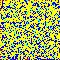

Learning rate:  0.001
Loss = tensor(1.7719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7572, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  0


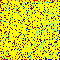

Learning rate:  0.001
Loss = tensor(1.7444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7440, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


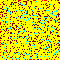

Learning rate:  0.001
Loss = tensor(1.7417, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7439, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7404, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


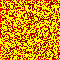

Learning rate:  0.001
Loss = tensor(1.7382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7380, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7289, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  1


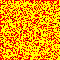

Learning rate:  0.001
Loss = tensor(1.7354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


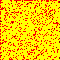

Learning rate:  0.001
Loss = tensor(1.7196, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7383, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7215, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7335, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


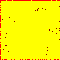

Learning rate:  0.001
Loss = tensor(1.7313, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7276, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7243, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  2


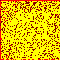

Learning rate:  0.001
Loss = tensor(1.7151, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


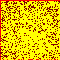

Learning rate:  0.001
Loss = tensor(1.7185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


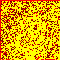

Learning rate:  0.001
Loss = tensor(1.7215, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7179, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7160, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  3


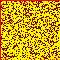

Learning rate:  0.001
Loss = tensor(1.7058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


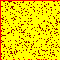

Learning rate:  0.001
Loss = tensor(1.7158, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


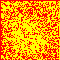

Learning rate:  0.001
Loss = tensor(1.7138, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7260, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7146, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7074, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7073, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  4


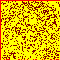

Learning rate:  0.001
Loss = tensor(1.7108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


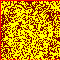

Learning rate:  0.001
Loss = tensor(1.7011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7110, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.7076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


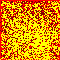

Learning rate:  0.001
Loss = tensor(1.6927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  5


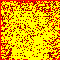

Learning rate:  0.001
Loss = tensor(1.6901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


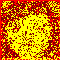

Learning rate:  0.001
Loss = tensor(1.6907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


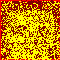

Learning rate:  0.001
Loss = tensor(1.6789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  6


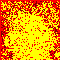

Learning rate:  0.001
Loss = tensor(1.6621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


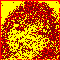

Learning rate:  0.001
Loss = tensor(1.6665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


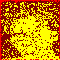

Learning rate:  0.001
Loss = tensor(1.6605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  7


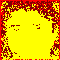

Learning rate:  0.001
Loss = tensor(1.6446, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


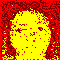

Learning rate:  0.001
Loss = tensor(1.6746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6335, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6529, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


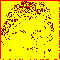

Learning rate:  0.001
Loss = tensor(1.6223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6427, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  8


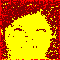

Learning rate:  0.001
Loss = tensor(1.6455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


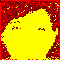

Learning rate:  0.001
Loss = tensor(1.6425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6220, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


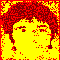

Learning rate:  0.001
Loss = tensor(1.6236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6235, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  9


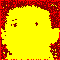

Learning rate:  0.001
Loss = tensor(1.6198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6262, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


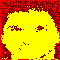

Learning rate:  0.001
Loss = tensor(1.6147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


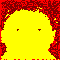

Learning rate:  0.001
Loss = tensor(1.6152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6230, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  10


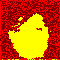

Learning rate:  0.001
Loss = tensor(1.6121, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


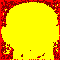

Learning rate:  0.001
Loss = tensor(1.6015, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6172, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


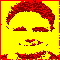

Learning rate:  0.001
Loss = tensor(1.6224, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  11


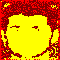

Learning rate:  0.001
Loss = tensor(1.6048, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


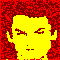

Learning rate:  0.001
Loss = tensor(1.5825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


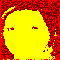

Learning rate:  0.001
Loss = tensor(1.6089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  12


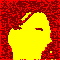

Learning rate:  0.001
Loss = tensor(1.6108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6117, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


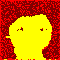

Learning rate:  0.001
Loss = tensor(1.5934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


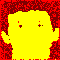

Learning rate:  0.001
Loss = tensor(1.6021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  13


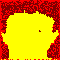

Learning rate:  0.001
Loss = tensor(1.5914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6122, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


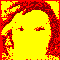

Learning rate:  0.001
Loss = tensor(1.6067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


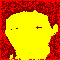

Learning rate:  0.001
Loss = tensor(1.5790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  14


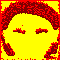

Learning rate:  0.001
Loss = tensor(1.5867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


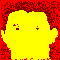

Learning rate:  0.001
Loss = tensor(1.6141, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5805, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


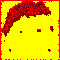

Learning rate:  0.001
Loss = tensor(1.5869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5875, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.6025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  15


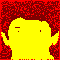

Learning rate:  0.001
Loss = tensor(1.5788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


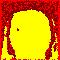

Learning rate:  0.001
Loss = tensor(1.6210, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


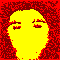

Learning rate:  0.001
Loss = tensor(1.5901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  16


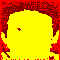

Learning rate:  0.001
Loss = tensor(1.5763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


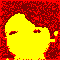

Learning rate:  0.001
Loss = tensor(1.5786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


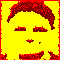

Learning rate:  0.001
Loss = tensor(1.6046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  17


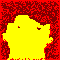

Learning rate:  0.001
Loss = tensor(1.5624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


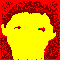

Learning rate:  0.001
Loss = tensor(1.5596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


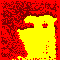

Learning rate:  0.001
Loss = tensor(1.5670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5582, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  18


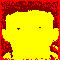

Learning rate:  0.001
Loss = tensor(1.5488, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


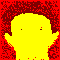

Learning rate:  0.001
Loss = tensor(1.5792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


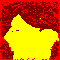

Learning rate:  0.001
Loss = tensor(1.5688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5604, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  19


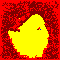

Learning rate:  0.001
Loss = tensor(1.5827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


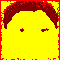

Learning rate:  0.001
Loss = tensor(1.5928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5392, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


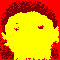

Learning rate:  0.001
Loss = tensor(1.5510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5434, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  20


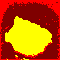

Learning rate:  0.001
Loss = tensor(1.5784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


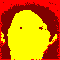

Learning rate:  0.001
Loss = tensor(1.5517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


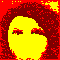

Learning rate:  0.001
Loss = tensor(1.5644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5546, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  21


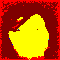

Learning rate:  0.001
Loss = tensor(1.5421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


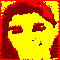

Learning rate:  0.001
Loss = tensor(1.5351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5424, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5593, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


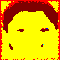

Learning rate:  0.001
Loss = tensor(1.5427, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5459, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5536, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  22


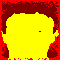

Learning rate:  0.001
Loss = tensor(1.5606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


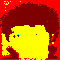

Learning rate:  0.001
Loss = tensor(1.5264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5419, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


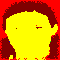

Learning rate:  0.001
Loss = tensor(1.5232, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5426, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5110, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  23


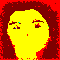

Learning rate:  0.001
Loss = tensor(1.5457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5273, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


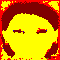

Learning rate:  0.001
Loss = tensor(1.5372, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


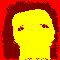

Learning rate:  0.001
Loss = tensor(1.5262, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5427, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  24


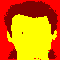

Learning rate:  0.001
Loss = tensor(1.5199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


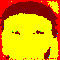

Learning rate:  0.001
Loss = tensor(1.5625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5225, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


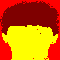

Learning rate:  0.001
Loss = tensor(1.5561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5210, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  25


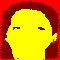

Learning rate:  0.001
Loss = tensor(1.5318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


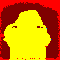

Learning rate:  0.001
Loss = tensor(1.5265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5422, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5274, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5348, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


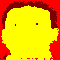

Learning rate:  0.001
Loss = tensor(1.5142, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5113, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5204, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  26


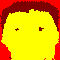

Learning rate:  0.001
Loss = tensor(1.5548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5261, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


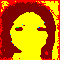

Learning rate:  0.001
Loss = tensor(1.5342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5420, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5398, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


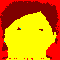

Learning rate:  0.001
Loss = tensor(1.5278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5372, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5210, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5197, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  27


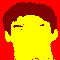

Learning rate:  0.001
Loss = tensor(1.5175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


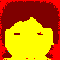

Learning rate:  0.001
Loss = tensor(1.5403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5449, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5362, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


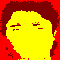

Learning rate:  0.001
Loss = tensor(1.5072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5270, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5277, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  28


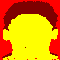

Learning rate:  0.001
Loss = tensor(1.5111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


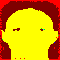

Learning rate:  0.001
Loss = tensor(1.5152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5278, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5282, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5323, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


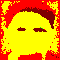

Learning rate:  0.001
Loss = tensor(1.5154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5286, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5270, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5095, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  29


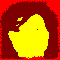

Learning rate:  0.001
Loss = tensor(1.5455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


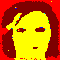

Learning rate:  0.0006
Loss = tensor(1.5332, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


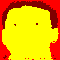

Learning rate:  0.0006
Loss = tensor(1.5293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5216, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5118, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5249, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  30


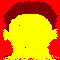

Learning rate:  0.0006
Loss = tensor(1.5276, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


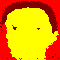

Learning rate:  0.0006
Loss = tensor(1.5498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5179, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


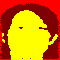

Learning rate:  0.0006
Loss = tensor(1.5175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  31


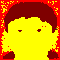

Learning rate:  0.0006
Loss = tensor(1.5053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


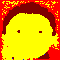

Learning rate:  0.0006
Loss = tensor(1.5056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5139, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


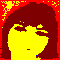

Learning rate:  0.0006
Loss = tensor(1.5116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5286, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  32


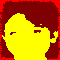

Learning rate:  0.0006
Loss = tensor(1.5114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


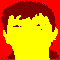

Learning rate:  0.0006
Loss = tensor(1.5167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5269, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


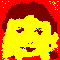

Learning rate:  0.0006
Loss = tensor(1.5139, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5258, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5128, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5096, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  33


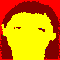

Learning rate:  0.0006
Loss = tensor(1.5115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5157, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


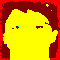

Learning rate:  0.0006
Loss = tensor(1.5047, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5247, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


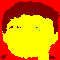

Learning rate:  0.0006
Loss = tensor(1.5207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5142, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  34


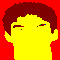

Learning rate:  0.0006
Loss = tensor(1.5457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


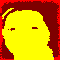

Learning rate:  0.0006
Loss = tensor(1.5287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


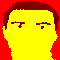

Learning rate:  0.0006
Loss = tensor(1.5058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5195, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  35


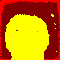

Learning rate:  0.0006
Loss = tensor(1.4939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


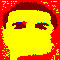

Learning rate:  0.0006
Loss = tensor(1.5169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5251, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5222, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5270, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


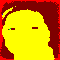

Learning rate:  0.0006
Loss = tensor(1.5066, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5096, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  36


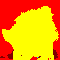

Learning rate:  0.0006
Loss = tensor(1.5018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


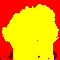

Learning rate:  0.0006
Loss = tensor(1.5044, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5096, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


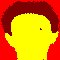

Learning rate:  0.0006
Loss = tensor(1.5307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5141, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5276, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5151, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  37


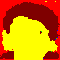

Learning rate:  0.0006
Loss = tensor(1.4957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5144, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


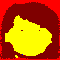

Learning rate:  0.0006
Loss = tensor(1.4947, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


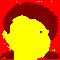

Learning rate:  0.0006
Loss = tensor(1.5092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  38


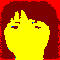

Learning rate:  0.0006
Loss = tensor(1.5013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5282, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


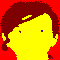

Learning rate:  0.0006
Loss = tensor(1.4992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


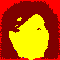

Learning rate:  0.0006
Loss = tensor(1.5161, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  39


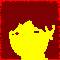

Learning rate:  0.0006
Loss = tensor(1.5027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5121, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


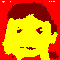

Learning rate:  0.0006
Loss = tensor(1.5094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5359, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


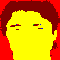

Learning rate:  0.0006
Loss = tensor(1.5012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  40


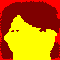

Learning rate:  0.0006
Loss = tensor(1.4910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


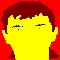

Learning rate:  0.0006
Loss = tensor(1.5131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5038, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5233, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


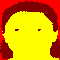

Learning rate:  0.0006
Loss = tensor(1.5187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  41


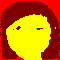

Learning rate:  0.0006
Loss = tensor(1.5037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5003, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


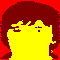

Learning rate:  0.0006
Loss = tensor(1.4999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5179, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


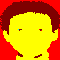

Learning rate:  0.0006
Loss = tensor(1.5130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5048, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  42


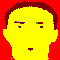

Learning rate:  0.0006
Loss = tensor(1.5156, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


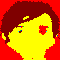

Learning rate:  0.0006
Loss = tensor(1.5180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


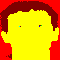

Learning rate:  0.0006
Loss = tensor(1.5199, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  43


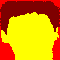

Learning rate:  0.0006
Loss = tensor(1.5190, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


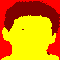

Learning rate:  0.0006
Loss = tensor(1.4937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5030, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5133, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5043, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


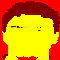

Learning rate:  0.0006
Loss = tensor(1.5063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5070, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  44


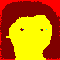

Learning rate:  0.0006
Loss = tensor(1.4958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


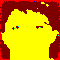

Learning rate:  0.0006
Loss = tensor(1.5236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5176, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


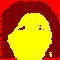

Learning rate:  0.0006
Loss = tensor(1.4994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4991, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  45


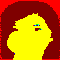

Learning rate:  0.0006
Loss = tensor(1.5117, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


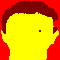

Learning rate:  0.0006
Loss = tensor(1.5205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5117, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


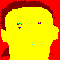

Learning rate:  0.0006
Loss = tensor(1.4958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  46


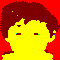

Learning rate:  0.0006
Loss = tensor(1.4984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


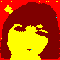

Learning rate:  0.0006
Loss = tensor(1.5059, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


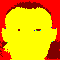

Learning rate:  0.0006
Loss = tensor(1.5064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5196, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  47


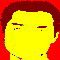

Learning rate:  0.0006
Loss = tensor(1.4992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


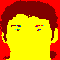

Learning rate:  0.0006
Loss = tensor(1.4958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


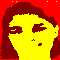

Learning rate:  0.0006
Loss = tensor(1.4940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  48


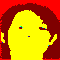

Learning rate:  0.0006
Loss = tensor(1.4960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


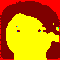

Learning rate:  0.0006
Loss = tensor(1.4870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5158, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5124, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5170, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4986, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


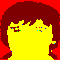

Learning rate:  0.0006
Loss = tensor(1.5089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  49


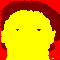

Learning rate:  0.0006
Loss = tensor(1.5079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


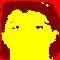

Learning rate:  0.0006
Loss = tensor(1.4811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5195, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5097, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


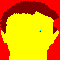

Learning rate:  0.0006
Loss = tensor(1.4985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  50


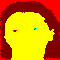

Learning rate:  0.0006
Loss = tensor(1.4940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


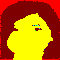

Learning rate:  0.0006
Loss = tensor(1.4909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5038, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


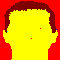

Learning rate:  0.0006
Loss = tensor(1.5036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5210, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  51


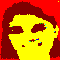

Learning rate:  0.0006
Loss = tensor(1.4784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


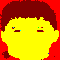

Learning rate:  0.0006
Loss = tensor(1.5020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


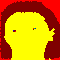

Learning rate:  0.0006
Loss = tensor(1.4967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5123, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  52


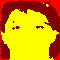

Learning rate:  0.0006
Loss = tensor(1.5101, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5095, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


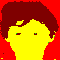

Learning rate:  0.0006
Loss = tensor(1.4829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5006, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4986, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


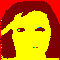

Learning rate:  0.0006
Loss = tensor(1.4932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  53


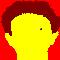

Learning rate:  0.0006
Loss = tensor(1.5244, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


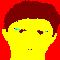

Learning rate:  0.0006
Loss = tensor(1.4882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4986, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


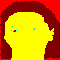

Learning rate:  0.0006
Loss = tensor(1.5046, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5096, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  54


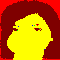

Learning rate:  0.0006
Loss = tensor(1.4948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


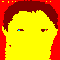

Learning rate:  0.0006
Loss = tensor(1.5024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5203, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4984, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


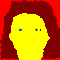

Learning rate:  0.0006
Loss = tensor(1.5009, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  55


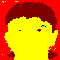

Learning rate:  0.0006
Loss = tensor(1.5112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


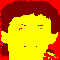

Learning rate:  0.0006
Loss = tensor(1.4953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5043, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5035, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4986, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


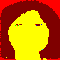

Learning rate:  0.0006
Loss = tensor(1.5081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5123, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  56


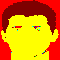

Learning rate:  0.0006
Loss = tensor(1.4902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4936, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


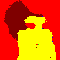

Learning rate:  0.0006
Loss = tensor(1.4952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5042, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


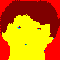

Learning rate:  0.0006
Loss = tensor(1.5005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5038, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  57


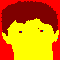

Learning rate:  0.0006
Loss = tensor(1.5113, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


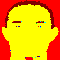

Learning rate:  0.0006
Loss = tensor(1.4856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


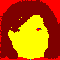

Learning rate:  0.0006
Loss = tensor(1.5113, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5120, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5038, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  58


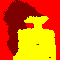

Learning rate:  0.0006
Loss = tensor(1.5018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


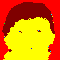

Learning rate:  0.0006
Loss = tensor(1.5000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5048, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


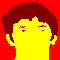

Learning rate:  0.0006
Loss = tensor(1.4912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  59


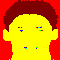

Learning rate:  0.0006
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


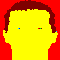

Learning rate:  0.00035999999999999997
Loss = tensor(1.4939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5232, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


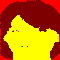

Learning rate:  0.00035999999999999997
Loss = tensor(1.4908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  60


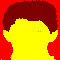

Learning rate:  0.00035999999999999997
Loss = tensor(1.4926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


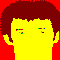

Learning rate:  0.00035999999999999997
Loss = tensor(1.4946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


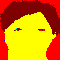

Learning rate:  0.00035999999999999997
Loss = tensor(1.5147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  61


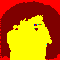

Learning rate:  0.00035999999999999997
Loss = tensor(1.4993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


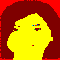

Learning rate:  0.00035999999999999997
Loss = tensor(1.4977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


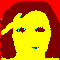

Learning rate:  0.00035999999999999997
Loss = tensor(1.4863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  62


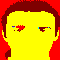

Learning rate:  0.00035999999999999997
Loss = tensor(1.5094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


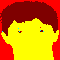

Learning rate:  0.00035999999999999997
Loss = tensor(1.5094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5117, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


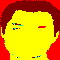

Learning rate:  0.00035999999999999997
Loss = tensor(1.4876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5048, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  63


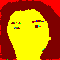

Learning rate:  0.00035999999999999997
Loss = tensor(1.5017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


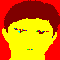

Learning rate:  0.00035999999999999997
Loss = tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5045, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


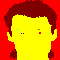

Learning rate:  0.00035999999999999997
Loss = tensor(1.4981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5124, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  64


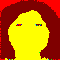

Learning rate:  0.00035999999999999997
Loss = tensor(1.5060, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5071, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


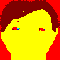

Learning rate:  0.00035999999999999997
Loss = tensor(1.4937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


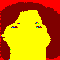

Learning rate:  0.00035999999999999997
Loss = tensor(1.4941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5101, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  65


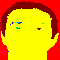

Learning rate:  0.00035999999999999997
Loss = tensor(1.4862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


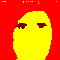

Learning rate:  0.00035999999999999997
Loss = tensor(1.4754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4971, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


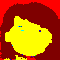

Learning rate:  0.00035999999999999997
Loss = tensor(1.5147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  66


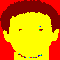

Learning rate:  0.00035999999999999997
Loss = tensor(1.5031, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


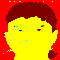

Learning rate:  0.00035999999999999997
Loss = tensor(1.4815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


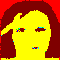

Learning rate:  0.00035999999999999997
Loss = tensor(1.5147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  67


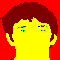

Learning rate:  0.00035999999999999997
Loss = tensor(1.5092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5017, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


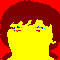

Learning rate:  0.00035999999999999997
Loss = tensor(1.5004, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4986, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5112, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


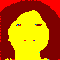

Learning rate:  0.00035999999999999997
Loss = tensor(1.4874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  68


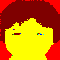

Learning rate:  0.00035999999999999997
Loss = tensor(1.4841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


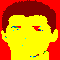

Learning rate:  0.00035999999999999997
Loss = tensor(1.4888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


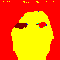

Learning rate:  0.00035999999999999997
Loss = tensor(1.4899, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4955, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  69


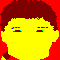

Learning rate:  0.00035999999999999997
Loss = tensor(1.5049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4875, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


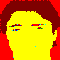

Learning rate:  0.00035999999999999997
Loss = tensor(1.4715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4956, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


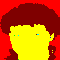

Learning rate:  0.00035999999999999997
Loss = tensor(1.5063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  70


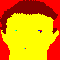

Learning rate:  0.00035999999999999997
Loss = tensor(1.5133, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


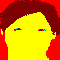

Learning rate:  0.00035999999999999997
Loss = tensor(1.5248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


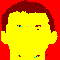

Learning rate:  0.00035999999999999997
Loss = tensor(1.5041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  71


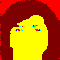

Learning rate:  0.00035999999999999997
Loss = tensor(1.4884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


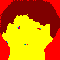

Learning rate:  0.00035999999999999997
Loss = tensor(1.4958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


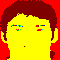

Learning rate:  0.00035999999999999997
Loss = tensor(1.5105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  72


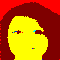

Learning rate:  0.00035999999999999997
Loss = tensor(1.4785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5045, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


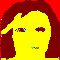

Learning rate:  0.00035999999999999997
Loss = tensor(1.4963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4866, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


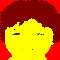

Learning rate:  0.00035999999999999997
Loss = tensor(1.4859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5047, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  73


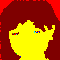

Learning rate:  0.00035999999999999997
Loss = tensor(1.5050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


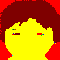

Learning rate:  0.00035999999999999997
Loss = tensor(1.5072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


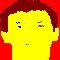

Learning rate:  0.00035999999999999997
Loss = tensor(1.4954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5038, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  74


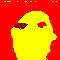

Learning rate:  0.00035999999999999997
Loss = tensor(1.4834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


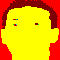

Learning rate:  0.00035999999999999997
Loss = tensor(1.4967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5095, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


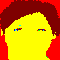

Learning rate:  0.00035999999999999997
Loss = tensor(1.4913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  75


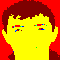

Learning rate:  0.00035999999999999997
Loss = tensor(1.4937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4986, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


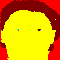

Learning rate:  0.00035999999999999997
Loss = tensor(1.5167, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5080, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4904, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


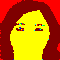

Learning rate:  0.00035999999999999997
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  76


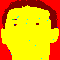

Learning rate:  0.00035999999999999997
Loss = tensor(1.4960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


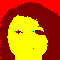

Learning rate:  0.00035999999999999997
Loss = tensor(1.4947, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


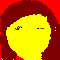

Learning rate:  0.00035999999999999997
Loss = tensor(1.5150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4861, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  77


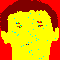

Learning rate:  0.00035999999999999997
Loss = tensor(1.4850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


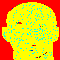

Learning rate:  0.00035999999999999997
Loss = tensor(1.4915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4925, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


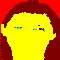

Learning rate:  0.00035999999999999997
Loss = tensor(1.4835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5120, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  78


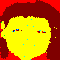

Learning rate:  0.00035999999999999997
Loss = tensor(1.4967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


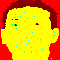

Learning rate:  0.00035999999999999997
Loss = tensor(1.5079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4962, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


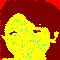

Learning rate:  0.00035999999999999997
Loss = tensor(1.4954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4969, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4866, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  79


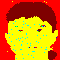

Learning rate:  0.00035999999999999997
Loss = tensor(1.4878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


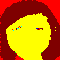

Learning rate:  0.00035999999999999997
Loss = tensor(1.4932, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


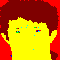

Learning rate:  0.00035999999999999997
Loss = tensor(1.5069, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4965, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  80


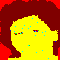

Learning rate:  0.00035999999999999997
Loss = tensor(1.4921, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


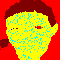

Learning rate:  0.00035999999999999997
Loss = tensor(1.4849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


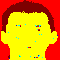

Learning rate:  0.00035999999999999997
Loss = tensor(1.4998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5018, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5057, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  81


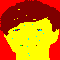

Learning rate:  0.00035999999999999997
Loss = tensor(1.4831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


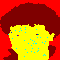

Learning rate:  0.00035999999999999997
Loss = tensor(1.4845, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


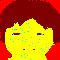

Learning rate:  0.00035999999999999997
Loss = tensor(1.4913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4934, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  82


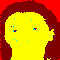

Learning rate:  0.00035999999999999997
Loss = tensor(1.4977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


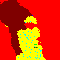

Learning rate:  0.00035999999999999997
Loss = tensor(1.4976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4766, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


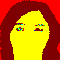

Learning rate:  0.00035999999999999997
Loss = tensor(1.5045, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5010, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  83


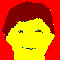

Learning rate:  0.00035999999999999997
Loss = tensor(1.5173, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


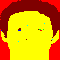

Learning rate:  0.00035999999999999997
Loss = tensor(1.5007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5144, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


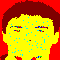

Learning rate:  0.00035999999999999997
Loss = tensor(1.4890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  84


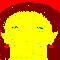

Learning rate:  0.00035999999999999997
Loss = tensor(1.4777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


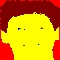

Learning rate:  0.00035999999999999997
Loss = tensor(1.5154, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4845, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


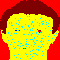

Learning rate:  0.00035999999999999997
Loss = tensor(1.4879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4875, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  85


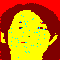

Learning rate:  0.00035999999999999997
Loss = tensor(1.5091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


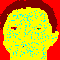

Learning rate:  0.00035999999999999997
Loss = tensor(1.5013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5027, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


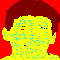

Learning rate:  0.00035999999999999997
Loss = tensor(1.4779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  86


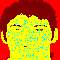

Learning rate:  0.00035999999999999997
Loss = tensor(1.4923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


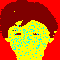

Learning rate:  0.00035999999999999997
Loss = tensor(1.4926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5300, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4971, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


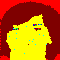

Learning rate:  0.00035999999999999997
Loss = tensor(1.5023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  87


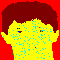

Learning rate:  0.00035999999999999997
Loss = tensor(1.4671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


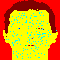

Learning rate:  0.00035999999999999997
Loss = tensor(1.4859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


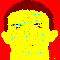

Learning rate:  0.00035999999999999997
Loss = tensor(1.5132, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5094, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  88


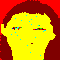

Learning rate:  0.00035999999999999997
Loss = tensor(1.4928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


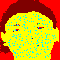

Learning rate:  0.00035999999999999997
Loss = tensor(1.4958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


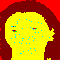

Learning rate:  0.00035999999999999997
Loss = tensor(1.4992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  89


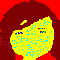

Learning rate:  0.00035999999999999997
Loss = tensor(1.5062, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


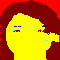

Learning rate:  0.00021599999999999996
Loss = tensor(1.4743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


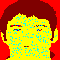

Learning rate:  0.00021599999999999996
Loss = tensor(1.4869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5052, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  90


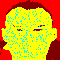

Learning rate:  0.00021599999999999996
Loss = tensor(1.4959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


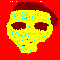

Learning rate:  0.00021599999999999996
Loss = tensor(1.5009, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4979, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


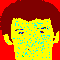

Learning rate:  0.00021599999999999996
Loss = tensor(1.4993, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5095, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5007, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  91


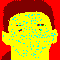

Learning rate:  0.00021599999999999996
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


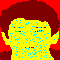

Learning rate:  0.00021599999999999996
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


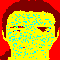

Learning rate:  0.00021599999999999996
Loss = tensor(1.4954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  92


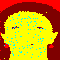

Learning rate:  0.00021599999999999996
Loss = tensor(1.5181, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


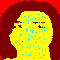

Learning rate:  0.00021599999999999996
Loss = tensor(1.4972, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4970, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


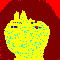

Learning rate:  0.00021599999999999996
Loss = tensor(1.5178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4999, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5038, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  93


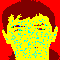

Learning rate:  0.00021599999999999996
Loss = tensor(1.4872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


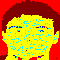

Learning rate:  0.00021599999999999996
Loss = tensor(1.4911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5009, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


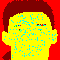

Learning rate:  0.00021599999999999996
Loss = tensor(1.4937, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  94


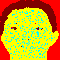

Learning rate:  0.00021599999999999996
Loss = tensor(1.4858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


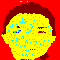

Learning rate:  0.00021599999999999996
Loss = tensor(1.4770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5142, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


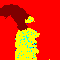

Learning rate:  0.00021599999999999996
Loss = tensor(1.5049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  95


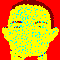

Learning rate:  0.00021599999999999996
Loss = tensor(1.4850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


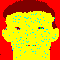

Learning rate:  0.00021599999999999996
Loss = tensor(1.4916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


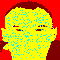

Learning rate:  0.00021599999999999996
Loss = tensor(1.4986, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  96


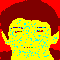

Learning rate:  0.00021599999999999996
Loss = tensor(1.4874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


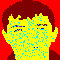

Learning rate:  0.00021599999999999996
Loss = tensor(1.4957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4835, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4998, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


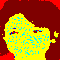

Learning rate:  0.00021599999999999996
Loss = tensor(1.4825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5065, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5153, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  97


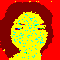

Learning rate:  0.00021599999999999996
Loss = tensor(1.5093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


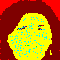

Learning rate:  0.00021599999999999996
Loss = tensor(1.4880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4947, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


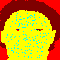

Learning rate:  0.00021599999999999996
Loss = tensor(1.4806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4989, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5141, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  98


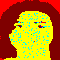

Learning rate:  0.00021599999999999996
Loss = tensor(1.4988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4936, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


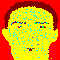

Learning rate:  0.00021599999999999996
Loss = tensor(1.4777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4902, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5431, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


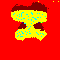

Learning rate:  0.00021599999999999996
Loss = tensor(1.4961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  99


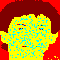

Learning rate:  0.00021599999999999996
Loss = tensor(1.4698, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


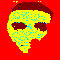

Learning rate:  0.00021599999999999996
Loss = tensor(1.4940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


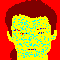

Learning rate:  0.00021599999999999996
Loss = tensor(1.5023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  100


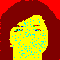

Learning rate:  0.00021599999999999996
Loss = tensor(1.4755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5236, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


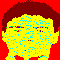

Learning rate:  0.00021599999999999996
Loss = tensor(1.4740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


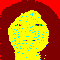

Learning rate:  0.00021599999999999996
Loss = tensor(1.4881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  101


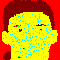

Learning rate:  0.00021599999999999996
Loss = tensor(1.4898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4928, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


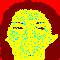

Learning rate:  0.00021599999999999996
Loss = tensor(1.5014, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5238, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


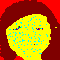

Learning rate:  0.00021599999999999996
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  102


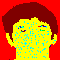

Learning rate:  0.00021599999999999996
Loss = tensor(1.4857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


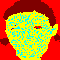

Learning rate:  0.00021599999999999996
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


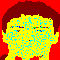

Learning rate:  0.00021599999999999996
Loss = tensor(1.5090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4960, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  103


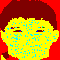

Learning rate:  0.00021599999999999996
Loss = tensor(1.5169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


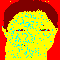

Learning rate:  0.00021599999999999996
Loss = tensor(1.4884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5066, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


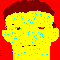

Learning rate:  0.00021599999999999996
Loss = tensor(1.4885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4948, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  104


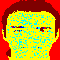

Learning rate:  0.00021599999999999996
Loss = tensor(1.4840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


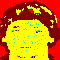

Learning rate:  0.00021599999999999996
Loss = tensor(1.4881, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


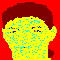

Learning rate:  0.00021599999999999996
Loss = tensor(1.4888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4958, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  105


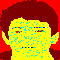

Learning rate:  0.00021599999999999996
Loss = tensor(1.4811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


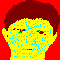

Learning rate:  0.00021599999999999996
Loss = tensor(1.4843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5173, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4996, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


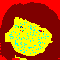

Learning rate:  0.00021599999999999996
Loss = tensor(1.5116, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4946, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  106


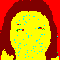

Learning rate:  0.00021599999999999996
Loss = tensor(1.4849, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5024, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


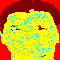

Learning rate:  0.00021599999999999996
Loss = tensor(1.4926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


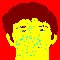

Learning rate:  0.00021599999999999996
Loss = tensor(1.5029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5378, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4689, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  107


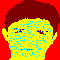

Learning rate:  0.00021599999999999996
Loss = tensor(1.5058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


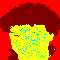

Learning rate:  0.00021599999999999996
Loss = tensor(1.4957, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4973, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


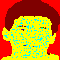

Learning rate:  0.00021599999999999996
Loss = tensor(1.4803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  108


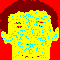

Learning rate:  0.00021599999999999996
Loss = tensor(1.4945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


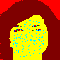

Learning rate:  0.00021599999999999996
Loss = tensor(1.5155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


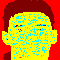

Learning rate:  0.00021599999999999996
Loss = tensor(1.4786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  109


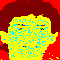

Learning rate:  0.00021599999999999996
Loss = tensor(1.4916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


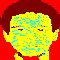

Learning rate:  0.00021599999999999996
Loss = tensor(1.4813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


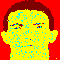

Learning rate:  0.00021599999999999996
Loss = tensor(1.5256, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5016, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4846, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4943, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  110


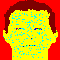

Learning rate:  0.00021599999999999996
Loss = tensor(1.4741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


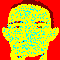

Learning rate:  0.00021599999999999996
Loss = tensor(1.4716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4903, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


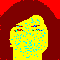

Learning rate:  0.00021599999999999996
Loss = tensor(1.5126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  111


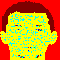

Learning rate:  0.00021599999999999996
Loss = tensor(1.4992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4919, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


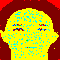

Learning rate:  0.00021599999999999996
Loss = tensor(1.4750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4647, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5135, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


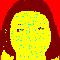

Learning rate:  0.00021599999999999996
Loss = tensor(1.4944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  112


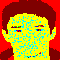

Learning rate:  0.00021599999999999996
Loss = tensor(1.4833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


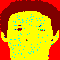

Learning rate:  0.00021599999999999996
Loss = tensor(1.4882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


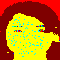

Learning rate:  0.00021599999999999996
Loss = tensor(1.5086, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5207, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5060, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  113


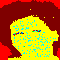

Learning rate:  0.00021599999999999996
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


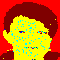

Learning rate:  0.00021599999999999996
Loss = tensor(1.4851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


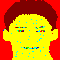

Learning rate:  0.00021599999999999996
Loss = tensor(1.4890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5133, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5042, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5244, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  114


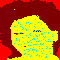

Learning rate:  0.00021599999999999996
Loss = tensor(1.4774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


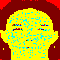

Learning rate:  0.00021599999999999996
Loss = tensor(1.4752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5172, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5000, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


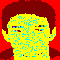

Learning rate:  0.00021599999999999996
Loss = tensor(1.4852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4964, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5109, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  115


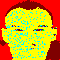

Learning rate:  0.00021599999999999996
Loss = tensor(1.4842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4949, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


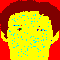

Learning rate:  0.00021599999999999996
Loss = tensor(1.4977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4907, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


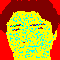

Learning rate:  0.00021599999999999996
Loss = tensor(1.4810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  116


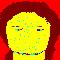

Learning rate:  0.00021599999999999996
Loss = tensor(1.4901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


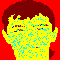

Learning rate:  0.00021599999999999996
Loss = tensor(1.5227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5025, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


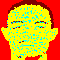

Learning rate:  0.00021599999999999996
Loss = tensor(1.4935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5121, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  117


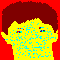

Learning rate:  0.00021599999999999996
Loss = tensor(1.4909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4852, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


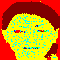

Learning rate:  0.00021599999999999996
Loss = tensor(1.4808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


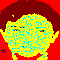

Learning rate:  0.00021599999999999996
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5037, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  118


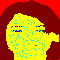

Learning rate:  0.00021599999999999996
Loss = tensor(1.4889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


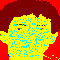

Learning rate:  0.00021599999999999996
Loss = tensor(1.4826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5181, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


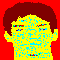

Learning rate:  0.00021599999999999996
Loss = tensor(1.4821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  119


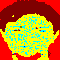

Learning rate:  0.00021599999999999996
Loss = tensor(1.4704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5073, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


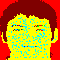

Learning rate:  0.00021599999999999996
Loss = tensor(1.4954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4915, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


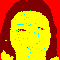

Learning rate:  0.00021599999999999996
Loss = tensor(1.4813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4922, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5101, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  120


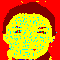

Learning rate:  0.00021599999999999996
Loss = tensor(1.4783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


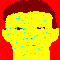

Learning rate:  0.00021599999999999996
Loss = tensor(1.4775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4959, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4952, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


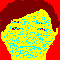

Learning rate:  0.00021599999999999996
Loss = tensor(1.4832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4844, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  121


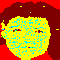

Learning rate:  0.00021599999999999996
Loss = tensor(1.4783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


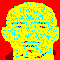

Learning rate:  0.00021599999999999996
Loss = tensor(1.4847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


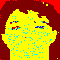

Learning rate:  0.00021599999999999996
Loss = tensor(1.4797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  122


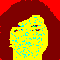

Learning rate:  0.00021599999999999996
Loss = tensor(1.4827, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


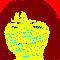

Learning rate:  0.00021599999999999996
Loss = tensor(1.4833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4763, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


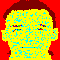

Learning rate:  0.00021599999999999996
Loss = tensor(1.5080, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  123


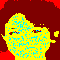

Learning rate:  0.00021599999999999996
Loss = tensor(1.4882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5229, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


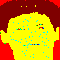

Learning rate:  0.00021599999999999996
Loss = tensor(1.4888, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4950, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


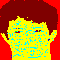

Learning rate:  0.00021599999999999996
Loss = tensor(1.5066, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4725, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4935, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  124


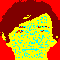

Learning rate:  0.00021599999999999996
Loss = tensor(1.5098, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


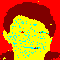

Learning rate:  0.00021599999999999996
Loss = tensor(1.5119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5114, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


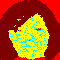

Learning rate:  0.00021599999999999996
Loss = tensor(1.5136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4829, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  125


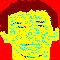

Learning rate:  0.00021599999999999996
Loss = tensor(1.4913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


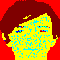

Learning rate:  0.00021599999999999996
Loss = tensor(1.5166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4774, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


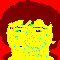

Learning rate:  0.00021599999999999996
Loss = tensor(1.4758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5091, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4866, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  126


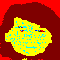

Learning rate:  0.00021599999999999996
Loss = tensor(1.4754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5252, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


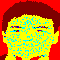

Learning rate:  0.00021599999999999996
Loss = tensor(1.4767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


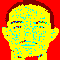

Learning rate:  0.00021599999999999996
Loss = tensor(1.5393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4945, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  127


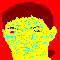

Learning rate:  0.00021599999999999996
Loss = tensor(1.4806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


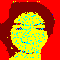

Learning rate:  0.00021599999999999996
Loss = tensor(1.4838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4917, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


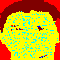

Learning rate:  0.00021599999999999996
Loss = tensor(1.4966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5093, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  128


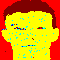

Learning rate:  0.00021599999999999996
Loss = tensor(1.5032, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


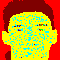

Learning rate:  0.00021599999999999996
Loss = tensor(1.4953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


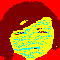

Learning rate:  0.00021599999999999996
Loss = tensor(1.4750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5009, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  129


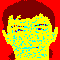

Learning rate:  0.00021599999999999996
Loss = tensor(1.5090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


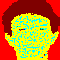

Learning rate:  0.00021599999999999996
Loss = tensor(1.4975, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5200, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4890, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5235, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


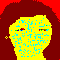

Learning rate:  0.00021599999999999996
Loss = tensor(1.4721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4905, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  130


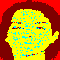

Learning rate:  0.00021599999999999996
Loss = tensor(1.4721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4982, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


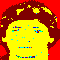

Learning rate:  0.00021599999999999996
Loss = tensor(1.5051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5131, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4983, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


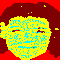

Learning rate:  0.00021599999999999996
Loss = tensor(1.4851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4784, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5044, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  131


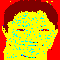

Learning rate:  0.00021599999999999996
Loss = tensor(1.4889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


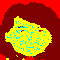

Learning rate:  0.00021599999999999996
Loss = tensor(1.5001, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4920, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5041, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4956, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


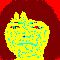

Learning rate:  0.00021599999999999996
Loss = tensor(1.4845, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5074, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4889, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  132


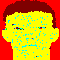

Learning rate:  0.00021599999999999996
Loss = tensor(1.4767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


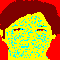

Learning rate:  0.00021599999999999996
Loss = tensor(1.4661, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5219, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5348, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


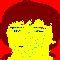

Learning rate:  0.00021599999999999996
Loss = tensor(1.4726, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4801, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4908, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  133


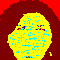

Learning rate:  0.00021599999999999996
Loss = tensor(1.5105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4977, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


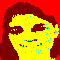

Learning rate:  0.00021599999999999996
Loss = tensor(1.4811, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


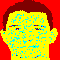

Learning rate:  0.00021599999999999996
Loss = tensor(1.5456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5179, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  134


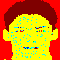

Learning rate:  0.00021599999999999996
Loss = tensor(1.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


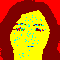

Learning rate:  0.00021599999999999996
Loss = tensor(1.4798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


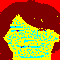

Learning rate:  0.00021599999999999996
Loss = tensor(1.4884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5389, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  135


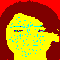

Learning rate:  0.00021599999999999996
Loss = tensor(1.4824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


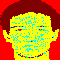

Learning rate:  0.00021599999999999996
Loss = tensor(1.4677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4900, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4834, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


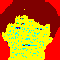

Learning rate:  0.00021599999999999996
Loss = tensor(1.5117, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  136


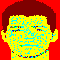

Learning rate:  0.00021599999999999996
Loss = tensor(1.5102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


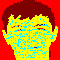

Learning rate:  0.00021599999999999996
Loss = tensor(1.4771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


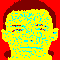

Learning rate:  0.00021599999999999996
Loss = tensor(1.4894, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  137


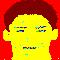

Learning rate:  0.00021599999999999996
Loss = tensor(1.5164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


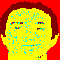

Learning rate:  0.00021599999999999996
Loss = tensor(1.5184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4857, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


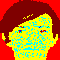

Learning rate:  0.00021599999999999996
Loss = tensor(1.4791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  138


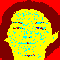

Learning rate:  0.00021599999999999996
Loss = tensor(1.4730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


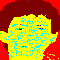

Learning rate:  0.00021599999999999996
Loss = tensor(1.4803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4700, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5171, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


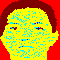

Learning rate:  0.00021599999999999996
Loss = tensor(1.4866, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4766, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5137, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  139


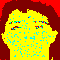

Learning rate:  0.00021599999999999996
Loss = tensor(1.4822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


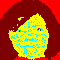

Learning rate:  0.00021599999999999996
Loss = tensor(1.5130, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4747, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4862, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


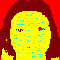

Learning rate:  0.00021599999999999996
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  140


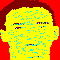

Learning rate:  0.00021599999999999996
Loss = tensor(1.4830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


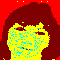

Learning rate:  0.00021599999999999996
Loss = tensor(1.5075, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


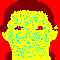

Learning rate:  0.00021599999999999996
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5067, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  141


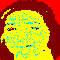

Learning rate:  0.00021599999999999996
Loss = tensor(1.5265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


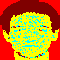

Learning rate:  0.00021599999999999996
Loss = tensor(1.4924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5169, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


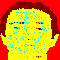

Learning rate:  0.00021599999999999996
Loss = tensor(1.4843, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  142


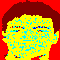

Learning rate:  0.00021599999999999996
Loss = tensor(1.5034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4756, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


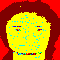

Learning rate:  0.00021599999999999996
Loss = tensor(1.4836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5072, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5265, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


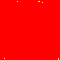

Learning rate:  0.00021599999999999996
Loss = tensor(1.4772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4988, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4701, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5191, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4754, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  143


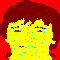

Learning rate:  0.00021599999999999996
Loss = tensor(1.4712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


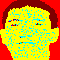

Learning rate:  0.00021599999999999996
Loss = tensor(1.4876, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4995, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


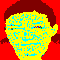

Learning rate:  0.00021599999999999996
Loss = tensor(1.4772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4766, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4796, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  144


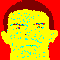

Learning rate:  0.00021599999999999996
Loss = tensor(1.4771, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


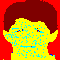

Learning rate:  0.00021599999999999996
Loss = tensor(1.5254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5066, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


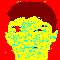

Learning rate:  0.00021599999999999996
Loss = tensor(1.4808, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4985, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  145


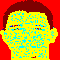

Learning rate:  0.00021599999999999996
Loss = tensor(1.5023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


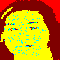

Learning rate:  0.00021599999999999996
Loss = tensor(1.4856, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


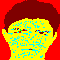

Learning rate:  0.00021599999999999996
Loss = tensor(1.4858, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5277, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  146


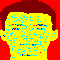

Learning rate:  0.00021599999999999996
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


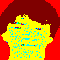

Learning rate:  0.00021599999999999996
Loss = tensor(1.4817, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


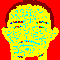

Learning rate:  0.00021599999999999996
Loss = tensor(1.5107, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5034, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5053, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  147


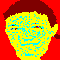

Learning rate:  0.00021599999999999996
Loss = tensor(1.4767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4748, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


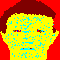

Learning rate:  0.00021599999999999996
Loss = tensor(1.4746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4863, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4868, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4778, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5105, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


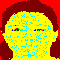

Learning rate:  0.00021599999999999996
Loss = tensor(1.4813, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4967, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  148


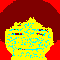

Learning rate:  0.00021599999999999996
Loss = tensor(1.4840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5356, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


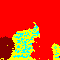

Learning rate:  0.00021599999999999996
Loss = tensor(1.4789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5009, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


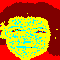

Learning rate:  0.00021599999999999996
Loss = tensor(1.4758, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4785, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  149


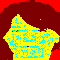

Learning rate:  0.00021599999999999996
Loss = tensor(1.4744, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4912, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


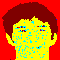

Learning rate:  0.00021599999999999996
Loss = tensor(1.4711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5319, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4845, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


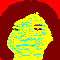

Learning rate:  0.00021599999999999996
Loss = tensor(1.4761, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4859, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4672, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  150


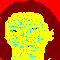

Learning rate:  0.00021599999999999996
Loss = tensor(1.4783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


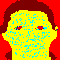

Learning rate:  0.00021599999999999996
Loss = tensor(1.4705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5310, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5038, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4927, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


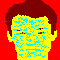

Learning rate:  0.00021599999999999996
Loss = tensor(1.5054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4750, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  151


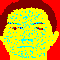

Learning rate:  0.00021599999999999996
Loss = tensor(1.4783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5473, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


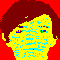

Learning rate:  0.00021599999999999996
Loss = tensor(1.5042, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4838, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


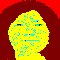

Learning rate:  0.00021599999999999996
Loss = tensor(1.4874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  152


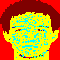

Learning rate:  0.00021599999999999996
Loss = tensor(1.4726, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5119, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


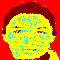

Learning rate:  0.00021599999999999996
Loss = tensor(1.5120, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


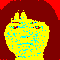

Learning rate:  0.00021599999999999996
Loss = tensor(1.4757, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  153


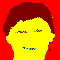

Learning rate:  0.00021599999999999996
Loss = tensor(1.4976, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4942, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


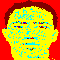

Learning rate:  0.00021599999999999996
Loss = tensor(1.4767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


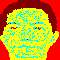

Learning rate:  0.00021599999999999996
Loss = tensor(1.4821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  154


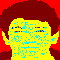

Learning rate:  0.00021599999999999996
Loss = tensor(1.5013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


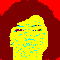

Learning rate:  0.00021599999999999996
Loss = tensor(1.5259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4751, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4823, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


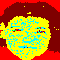

Learning rate:  0.00021599999999999996
Loss = tensor(1.5011, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  155


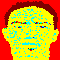

Learning rate:  0.00021599999999999996
Loss = tensor(1.5129, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5065, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


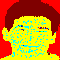

Learning rate:  0.00021599999999999996
Loss = tensor(1.4764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4916, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5077, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


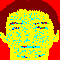

Learning rate:  0.00021599999999999996
Loss = tensor(1.4721, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  156


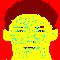

Learning rate:  0.00021599999999999996
Loss = tensor(1.5056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5087, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


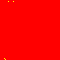

Learning rate:  0.00021599999999999996
Loss = tensor(1.4824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


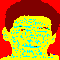

Learning rate:  0.00021599999999999996
Loss = tensor(1.4718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4978, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4764, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  157


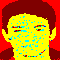

Learning rate:  0.00021599999999999996
Loss = tensor(1.5128, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


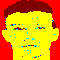

Learning rate:  0.00021599999999999996
Loss = tensor(1.4777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4777, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


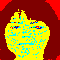

Learning rate:  0.00021599999999999996
Loss = tensor(1.4854, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4850, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5036, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  158


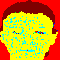

Learning rate:  0.00021599999999999996
Loss = tensor(1.5111, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5124, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


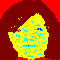

Learning rate:  0.00021599999999999996
Loss = tensor(1.4825, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4851, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


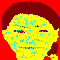

Learning rate:  0.00021599999999999996
Loss = tensor(1.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4800, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4824, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  159


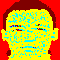

Learning rate:  0.00021599999999999996
Loss = tensor(1.4769, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


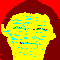

Learning rate:  0.00021599999999999996
Loss = tensor(1.4699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5349, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


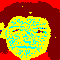

Learning rate:  0.00021599999999999996
Loss = tensor(1.4802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4939, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  160


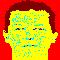

Learning rate:  0.00021599999999999996
Loss = tensor(1.4805, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


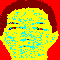

Learning rate:  0.00021599999999999996
Loss = tensor(1.4686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5152, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4832, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


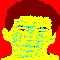

Learning rate:  0.00021599999999999996
Loss = tensor(1.5050, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4953, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5173, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4770, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  161


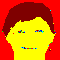

Learning rate:  0.00021599999999999996
Loss = tensor(1.4696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


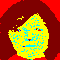

Learning rate:  0.00021599999999999996
Loss = tensor(1.4728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4676, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


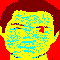

Learning rate:  0.00021599999999999996
Loss = tensor(1.4780, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5021, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4822, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  162


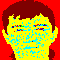

Learning rate:  0.00021599999999999996
Loss = tensor(1.4708, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


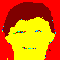

Learning rate:  0.00021599999999999996
Loss = tensor(1.5166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4733, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4821, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4872, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4855, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


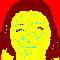

Learning rate:  0.00021599999999999996
Loss = tensor(1.4709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  163


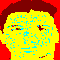

Learning rate:  0.00021599999999999996
Loss = tensor(1.5064, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4757, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


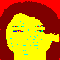

Learning rate:  0.00021599999999999996
Loss = tensor(1.5107, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


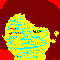

Learning rate:  0.00021599999999999996
Loss = tensor(1.4716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  164


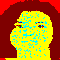

Learning rate:  0.00021599999999999996
Loss = tensor(1.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4742, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


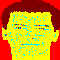

Learning rate:  0.00021599999999999996
Loss = tensor(1.4812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4768, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5061, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4708, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


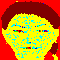

Learning rate:  0.00021599999999999996
Loss = tensor(1.5079, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4990, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  165


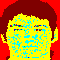

Learning rate:  0.00021599999999999996
Loss = tensor(1.4685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


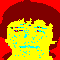

Learning rate:  0.00021599999999999996
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4749, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4641, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5132, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


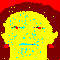

Learning rate:  0.00021599999999999996
Loss = tensor(1.5159, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5162, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  166


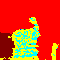

Learning rate:  0.00021599999999999996
Loss = tensor(1.4828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4818, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


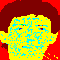

Learning rate:  0.00021599999999999996
Loss = tensor(1.4634, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4901, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5141, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


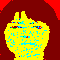

Learning rate:  0.00021599999999999996
Loss = tensor(1.5068, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4719, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  167


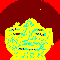

Learning rate:  0.00021599999999999996
Loss = tensor(1.4708, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4588, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


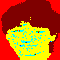

Learning rate:  0.00021599999999999996
Loss = tensor(1.4671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4931, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4930, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


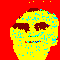

Learning rate:  0.00021599999999999996
Loss = tensor(1.4715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  168


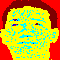

Learning rate:  0.00021599999999999996
Loss = tensor(1.5174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


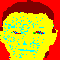

Learning rate:  0.00021599999999999996
Loss = tensor(1.5039, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4898, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


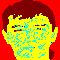

Learning rate:  0.00021599999999999996
Loss = tensor(1.4767, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4787, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4703, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5044, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  169


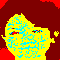

Learning rate:  0.00021599999999999996
Loss = tensor(1.4669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


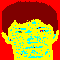

Learning rate:  0.00021599999999999996
Loss = tensor(1.4794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5150, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4877, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


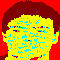

Learning rate:  0.00021599999999999996
Loss = tensor(1.5085, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4933, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4730, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  170


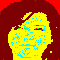

Learning rate:  0.00021599999999999996
Loss = tensor(1.4707, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


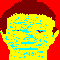

Learning rate:  0.00021599999999999996
Loss = tensor(1.4741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5089, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


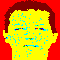

Learning rate:  0.00021599999999999996
Loss = tensor(1.4738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5056, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  171


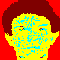

Learning rate:  0.00021599999999999996
Loss = tensor(1.4926, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4882, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


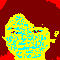

Learning rate:  0.00021599999999999996
Loss = tensor(1.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4884, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4893, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


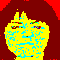

Learning rate:  0.00021599999999999996
Loss = tensor(1.4745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4941, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4865, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  172


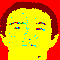

Learning rate:  0.00021599999999999996
Loss = tensor(1.4810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


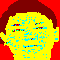

Learning rate:  0.00021599999999999996
Loss = tensor(1.5081, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4879, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5045, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


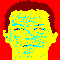

Learning rate:  0.00021599999999999996
Loss = tensor(1.4697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4870, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4860, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  173


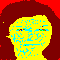

Learning rate:  0.00021599999999999996
Loss = tensor(1.4734, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4966, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


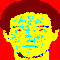

Learning rate:  0.00021599999999999996
Loss = tensor(1.4929, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4887, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4839, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


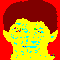

Learning rate:  0.00021599999999999996
Loss = tensor(1.5012, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4841, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4726, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  174


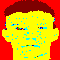

Learning rate:  0.00021599999999999996
Loss = tensor(1.4714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


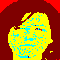

Learning rate:  0.00021599999999999996
Loss = tensor(1.4891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4802, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4840, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


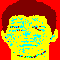

Learning rate:  0.00021599999999999996
Loss = tensor(1.4910, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4716, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5092, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  175


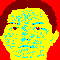

Learning rate:  0.00021599999999999996
Loss = tensor(1.4795, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5028, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


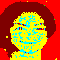

Learning rate:  0.00021599999999999996
Loss = tensor(1.4914, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4772, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5123, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4792, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


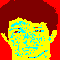

Learning rate:  0.00021599999999999996
Loss = tensor(1.4675, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5044, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  176


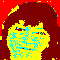

Learning rate:  0.00021599999999999996
Loss = tensor(1.4636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


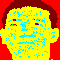

Learning rate:  0.00021599999999999996
Loss = tensor(1.4805, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4700, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5128, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


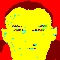

Learning rate:  0.00021599999999999996
Loss = tensor(1.4786, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4736, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4630, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  177


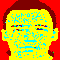

Learning rate:  0.00021599999999999996
Loss = tensor(1.4783, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4642, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


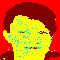

Learning rate:  0.00021599999999999996
Loss = tensor(1.4699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4663, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5066, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


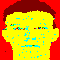

Learning rate:  0.00021599999999999996
Loss = tensor(1.4897, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4715, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  178


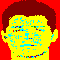

Learning rate:  0.00021599999999999996
Loss = tensor(1.5009, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4798, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


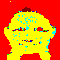

Learning rate:  0.00021599999999999996
Loss = tensor(1.4594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4871, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


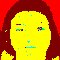

Learning rate:  0.00021599999999999996
Loss = tensor(1.4652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5615, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  179


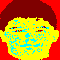

Learning rate:  0.00021599999999999996
Loss = tensor(1.4779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4781, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  180


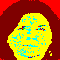

Learning rate:  0.00021599999999999996
Loss = tensor(1.5023, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4810, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4789, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  180


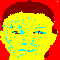

Learning rate:  0.00021599999999999996
Loss = tensor(1.4650, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4765, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4909, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  180


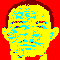

Learning rate:  0.00021599999999999996
Loss = tensor(1.5101, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  181


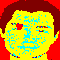

Learning rate:  0.00021599999999999996
Loss = tensor(1.4690, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4759, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4848, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4992, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4944, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  181


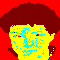

Learning rate:  0.00021599999999999996
Loss = tensor(1.5013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  181


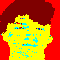

Learning rate:  0.00021599999999999996
Loss = tensor(1.4788, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4830, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  182


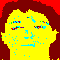

Learning rate:  0.00021599999999999996
Loss = tensor(1.4711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4873, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4708, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  182


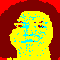

Learning rate:  0.00021599999999999996
Loss = tensor(1.4918, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5192, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4669, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  182


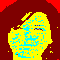

Learning rate:  0.00021599999999999996
Loss = tensor(1.5005, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4847, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  183


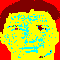

Learning rate:  0.00021599999999999996
Loss = tensor(1.4648, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4831, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4738, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4735, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  183


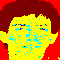

Learning rate:  0.00021599999999999996
Loss = tensor(1.4779, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4971, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4880, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5222, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4662, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  183


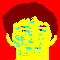

Learning rate:  0.00021599999999999996
Loss = tensor(1.4607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4755, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  184


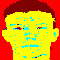

Learning rate:  0.00021599999999999996
Loss = tensor(1.4551, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4820, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4668, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4812, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  184


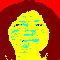

Learning rate:  0.00021599999999999996
Loss = tensor(1.4688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  184


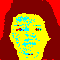

Learning rate:  0.00021599999999999996
Loss = tensor(1.5082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  185


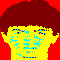

Learning rate:  0.00021599999999999996
Loss = tensor(1.4630, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4806, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4683, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  185


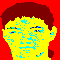

Learning rate:  0.00021599999999999996
Loss = tensor(1.4585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5216, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4741, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5043, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  185


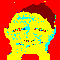

Learning rate:  0.00021599999999999996
Loss = tensor(1.5002, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  186


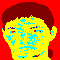

Learning rate:  0.00021599999999999996
Loss = tensor(1.4706, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4775, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  186


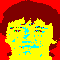

Learning rate:  0.00021599999999999996
Loss = tensor(1.4626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4704, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4631, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  186


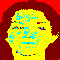

Learning rate:  0.00021599999999999996
Loss = tensor(1.4752, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4658, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  187


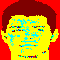

Learning rate:  0.00021599999999999996
Loss = tensor(1.4814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4621, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  187


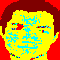

Learning rate:  0.00021599999999999996
Loss = tensor(1.4585, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4896, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4766, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4673, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  187


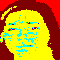

Learning rate:  0.00021599999999999996
Loss = tensor(1.4622, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4731, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  188


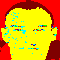

Learning rate:  0.00021599999999999996
Loss = tensor(1.5209, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5033, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  188


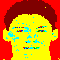

Learning rate:  0.00021599999999999996
Loss = tensor(1.4666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4586, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4727, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  188


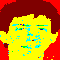

Learning rate:  0.00021599999999999996
Loss = tensor(1.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  189


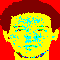

Learning rate:  0.00021599999999999996
Loss = tensor(1.4961, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4819, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  189


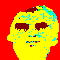

Learning rate:  0.00021599999999999996
Loss = tensor(1.4874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4613, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  189


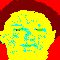

Learning rate:  0.00021599999999999996
Loss = tensor(1.4911, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4791, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  190


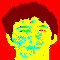

Learning rate:  0.00021599999999999996
Loss = tensor(1.4923, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4842, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  190


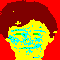

Learning rate:  0.00021599999999999996
Loss = tensor(1.4559, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4968, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4697, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4853, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  190


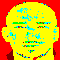

Learning rate:  0.00021599999999999996
Loss = tensor(1.4709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  191


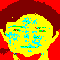

Learning rate:  0.00021599999999999996
Loss = tensor(1.4574, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4649, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  191


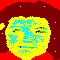

Learning rate:  0.00021599999999999996
Loss = tensor(1.4570, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5013, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4762, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  191


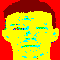

Learning rate:  0.00021599999999999996
Loss = tensor(1.4533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  192


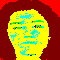

Learning rate:  0.00021599999999999996
Loss = tensor(1.5054, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4740, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4470, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  192


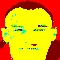

Learning rate:  0.00021599999999999996
Loss = tensor(1.4805, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4686, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4773, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4866, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  192


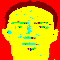

Learning rate:  0.00021599999999999996
Loss = tensor(1.4556, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4723, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  193


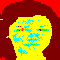

Learning rate:  0.00021599999999999996
Loss = tensor(1.4684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4645, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  193


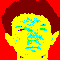

Learning rate:  0.00021599999999999996
Loss = tensor(1.4562, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5047, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4665, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  193


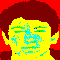

Learning rate:  0.00021599999999999996
Loss = tensor(1.4963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  194


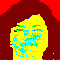

Learning rate:  0.00021599999999999996
Loss = tensor(1.5226, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4517, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4476, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4951, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  194


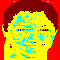

Learning rate:  0.00021599999999999996
Loss = tensor(1.4524, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4388, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4485, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4619, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  194


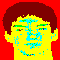

Learning rate:  0.00021599999999999996
Loss = tensor(1.4666, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  195


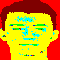

Learning rate:  0.00021599999999999996
Loss = tensor(1.4980, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4412, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  195


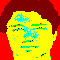

Learning rate:  0.00021599999999999996
Loss = tensor(1.4906, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4874, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4594, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4640, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4580, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  195


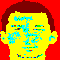

Learning rate:  0.00021599999999999996
Loss = tensor(1.4441, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  196


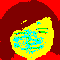

Learning rate:  0.00021599999999999996
Loss = tensor(1.4526, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4875, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4817, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4609, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  196


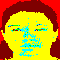

Learning rate:  0.00021599999999999996
Loss = tensor(1.4521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4664, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4963, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4519, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  196


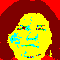

Learning rate:  0.00021599999999999996
Loss = tensor(1.4632, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4809, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  197


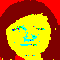

Learning rate:  0.00021599999999999996
Loss = tensor(1.4516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4971, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  197


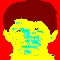

Learning rate:  0.00021599999999999996
Loss = tensor(1.4372, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4607, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  197


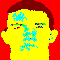

Learning rate:  0.00021599999999999996
Loss = tensor(1.4531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4437, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  198


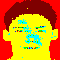

Learning rate:  0.00021599999999999996
Loss = tensor(1.4602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4531, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4424, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4878, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  198


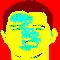

Learning rate:  0.00021599999999999996
Loss = tensor(1.4657, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4746, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4705, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  198


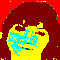

Learning rate:  0.00021599999999999996
Loss = tensor(1.4448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  199


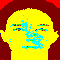

Learning rate:  0.00021599999999999996
Loss = tensor(1.4671, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4575, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4434, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  199


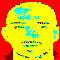

Learning rate:  0.00021599999999999996
Loss = tensor(1.4864, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4627, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  199


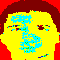

Learning rate:  0.00021599999999999996
Loss = tensor(1.4477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4403, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  200


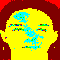

Learning rate:  0.00021599999999999996
Loss = tensor(1.4370, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4609, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  200


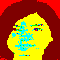

Learning rate:  0.00021599999999999996
Loss = tensor(1.4393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4954, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4373, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  200


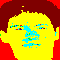

Learning rate:  0.00021599999999999996
Loss = tensor(1.4678, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5123, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  201


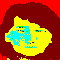

Learning rate:  0.00021599999999999996
Loss = tensor(1.4293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4747, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4722, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4333, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4456, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  201


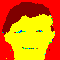

Learning rate:  0.00021599999999999996
Loss = tensor(1.4455, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4743, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4481, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  201


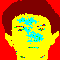

Learning rate:  0.00021599999999999996
Loss = tensor(1.4443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4790, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  202


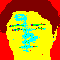

Learning rate:  0.00021599999999999996
Loss = tensor(1.4344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4365, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4358, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  202


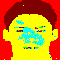

Learning rate:  0.00021599999999999996
Loss = tensor(1.4579, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4363, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4803, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4602, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  202


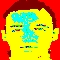

Learning rate:  0.00021599999999999996
Loss = tensor(1.4612, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4377, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  203


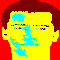

Learning rate:  0.00021599999999999996
Loss = tensor(1.4684, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4478, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4450, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4418, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  203


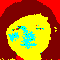

Learning rate:  0.00021599999999999996
Loss = tensor(1.4514, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4357, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4444, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5295, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  203


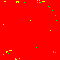

Learning rate:  0.00021599999999999996
Loss = tensor(1.5055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4682, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  204


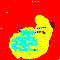

Learning rate:  0.00021599999999999996
Loss = tensor(1.4344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4895, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4344, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4867, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4495, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  204


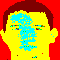

Learning rate:  0.00021599999999999996
Loss = tensor(1.4407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4405, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4508, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  204


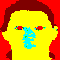

Learning rate:  0.00021599999999999996
Loss = tensor(1.4284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4596, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  205


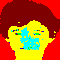

Learning rate:  0.00021599999999999996
Loss = tensor(1.4507, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  205


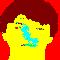

Learning rate:  0.00021599999999999996
Loss = tensor(1.4337, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4836, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5040, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4539, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  205


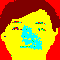

Learning rate:  0.00021599999999999996
Loss = tensor(1.4794, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  206


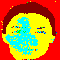

Learning rate:  0.00021599999999999996
Loss = tensor(1.4351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4837, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4493, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  206


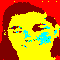

Learning rate:  0.00021599999999999996
Loss = tensor(1.4381, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4432, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4681, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4396, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4816, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  206


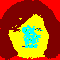

Learning rate:  0.00021599999999999996
Loss = tensor(1.4238, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4381, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  207


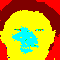

Learning rate:  0.00021599999999999996
Loss = tensor(1.4317, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4341, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4885, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  207


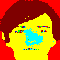

Learning rate:  0.00021599999999999996
Loss = tensor(1.4408, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4518, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4869, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  207


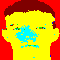

Learning rate:  0.00021599999999999996
Loss = tensor(1.4654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4591, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  208


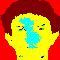

Learning rate:  0.00021599999999999996
Loss = tensor(1.4538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4439, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4458, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  208


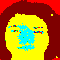

Learning rate:  0.00021599999999999996
Loss = tensor(1.4346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4435, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  208


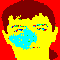

Learning rate:  0.00021599999999999996
Loss = tensor(1.4445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4389, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  209


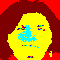

Learning rate:  0.00021599999999999996
Loss = tensor(1.4712, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4395, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4245, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4204, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4348, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  209


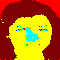

Learning rate:  0.00021599999999999996
Loss = tensor(1.4351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4737, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4350, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4291, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  209


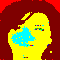

Learning rate:  0.00021599999999999996
Loss = tensor(1.4875, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4467, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  210


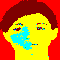

Learning rate:  0.00021599999999999996
Loss = tensor(1.4497, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4528, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4760, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4298, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  210


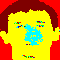

Learning rate:  0.00021599999999999996
Loss = tensor(1.4286, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4469, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4332, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4696, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4667, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  210


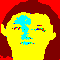

Learning rate:  0.00021599999999999996
Loss = tensor(1.4503, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  211


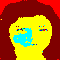

Learning rate:  0.00021599999999999996
Loss = tensor(1.4636, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4554, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4392, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4202, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  211


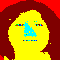

Learning rate:  0.00021599999999999996
Loss = tensor(1.4309, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4479, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4597, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5065, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  211


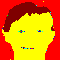

Learning rate:  0.00021599999999999996
Loss = tensor(1.4653, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  212


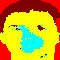

Learning rate:  0.00021599999999999996
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4804, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4242, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4573, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  212


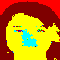

Learning rate:  0.00021599999999999996
Loss = tensor(1.4360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4319, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  212


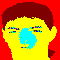

Learning rate:  0.00021599999999999996
Loss = tensor(1.4140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4776, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  213


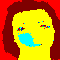

Learning rate:  0.00021599999999999996
Loss = tensor(1.4246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4413, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4228, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4714, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  213


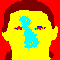

Learning rate:  0.00021599999999999996
Loss = tensor(1.4638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4314, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4245, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4258, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  213


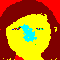

Learning rate:  0.00021599999999999996
Loss = tensor(1.4221, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4464, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  214


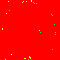

Learning rate:  0.00021599999999999996
Loss = tensor(1.4348, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4283, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4423, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4287, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4833, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  214


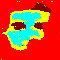

Learning rate:  0.00021599999999999996
Loss = tensor(1.4259, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4711, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4415, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4258, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  214


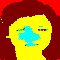

Learning rate:  0.00021599999999999996
Loss = tensor(1.4729, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4472, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  215


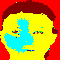

Learning rate:  0.00021599999999999996
Loss = tensor(1.4206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4709, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4228, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  215


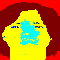

Learning rate:  0.00021599999999999996
Loss = tensor(1.4540, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4826, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4231, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  215


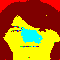

Learning rate:  0.00021599999999999996
Loss = tensor(1.4361, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  216


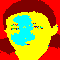

Learning rate:  0.00021599999999999996
Loss = tensor(1.4505, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4317, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4692, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  216


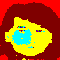

Learning rate:  0.00021599999999999996
Loss = tensor(1.4624, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4273, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4149, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  216


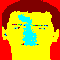

Learning rate:  0.00021599999999999996
Loss = tensor(1.4411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4717, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  217


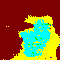

Learning rate:  0.00021599999999999996
Loss = tensor(1.4296, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4644, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4557, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4548, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  217


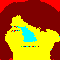

Learning rate:  0.00021599999999999996
Loss = tensor(1.4297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4563, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  217


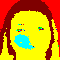

Learning rate:  0.00021599999999999996
Loss = tensor(1.4218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4595, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  218


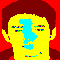

Learning rate:  0.00021599999999999996
Loss = tensor(1.4155, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4158, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5059, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4257, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4385, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  218


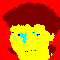

Learning rate:  0.00021599999999999996
Loss = tensor(1.4325, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4724, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4181, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4677, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  218


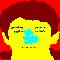

Learning rate:  0.00021599999999999996
Loss = tensor(1.4126, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  219


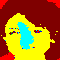

Learning rate:  0.00021599999999999996
Loss = tensor(1.4521, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4175, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4981, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  219


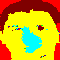

Learning rate:  0.00021599999999999996
Loss = tensor(1.4421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4427, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4243, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4136, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4535, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  219


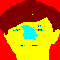

Learning rate:  0.00021599999999999996
Loss = tensor(1.4334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  220


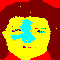

Learning rate:  0.00021599999999999996
Loss = tensor(1.4368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4883, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4391, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  220


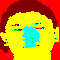

Learning rate:  0.00021599999999999996
Loss = tensor(1.4303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4799, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4297, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4132, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  220


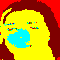

Learning rate:  0.00021599999999999996
Loss = tensor(1.4354, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4282, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  221


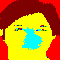

Learning rate:  0.00021599999999999996
Loss = tensor(1.4249, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4188, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4421, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4263, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  221


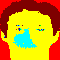

Learning rate:  0.00021599999999999996
Loss = tensor(1.4244, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4561, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4533, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4646, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  221


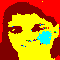

Learning rate:  0.00021599999999999996
Loss = tensor(1.4553, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  222


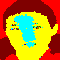

Learning rate:  0.00021599999999999996
Loss = tensor(1.4442, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4793, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4590, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4620, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4425, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  222


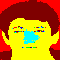

Learning rate:  0.00021599999999999996
Loss = tensor(1.4564, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4427, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4166, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4185, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4148, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  222


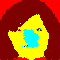

Learning rate:  0.00021599999999999996
Loss = tensor(1.4334, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4288, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  223


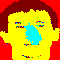

Learning rate:  0.00021599999999999996
Loss = tensor(1.4460, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4363, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4173, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.5019, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  223


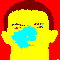

Learning rate:  0.00021599999999999996
Loss = tensor(1.4680, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4277, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4193, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  223


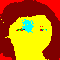

Learning rate:  0.00021599999999999996
Loss = tensor(1.4406, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4471, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  224


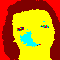

Learning rate:  0.00021599999999999996
Loss = tensor(1.4146, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4302, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4688, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  224


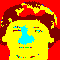

Learning rate:  0.00021599999999999996
Loss = tensor(1.4399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4309, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4638, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4132, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4346, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  224


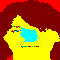

Learning rate:  0.00021599999999999996
Loss = tensor(1.4814, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4168, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  225


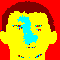

Learning rate:  0.00021599999999999996
Loss = tensor(1.4221, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4732, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4355, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4468, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4337, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  225


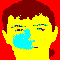

Learning rate:  0.00021599999999999996
Loss = tensor(1.4393, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4246, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4605, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4739, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  225


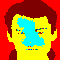

Learning rate:  0.00021599999999999996
Loss = tensor(1.4218, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  226


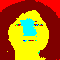

Learning rate:  0.00021599999999999996
Loss = tensor(1.4414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4994, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4494, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  226


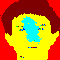

Learning rate:  0.00021599999999999996
Loss = tensor(1.4445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4387, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.3987, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  226


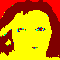

Learning rate:  0.00021599999999999996
Loss = tensor(1.4491, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4088, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  227


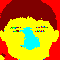

Learning rate:  0.00021599999999999996
Loss = tensor(1.4369, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4616, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4660, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4453, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  227


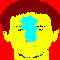

Learning rate:  0.00021599999999999996
Loss = tensor(1.4215, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4452, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4411, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4603, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  227


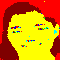

Learning rate:  0.00021599999999999996
Loss = tensor(1.4399, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  228


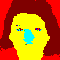

Learning rate:  0.00021599999999999996
Loss = tensor(1.4211, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4232, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4416, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  228


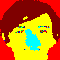

Learning rate:  0.00021599999999999996
Loss = tensor(1.4451, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4058, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4940, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4099, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  228


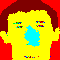

Learning rate:  0.00021599999999999996
Loss = tensor(1.4387, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4569, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  229


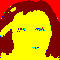

Learning rate:  0.00021599999999999996
Loss = tensor(1.4239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4264, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4550, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4182, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4397, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  229


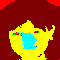

Learning rate:  0.00021599999999999996
Loss = tensor(1.4196, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4462, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4461, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4326, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  229


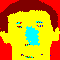

Learning rate:  0.00021599999999999996
Loss = tensor(1.4258, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4629, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  230


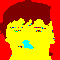

Learning rate:  0.00021599999999999996
Loss = tensor(1.4608, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4523, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4293, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4230, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  230


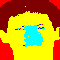

Learning rate:  0.00021599999999999996
Loss = tensor(1.4311, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4343, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4179, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4279, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  230


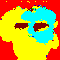

Learning rate:  0.00021599999999999996
Loss = tensor(1.4340, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4747, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  231


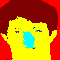

Learning rate:  0.00021599999999999996
Loss = tensor(1.4520, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4291, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4320, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4382, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4296, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  231


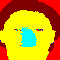

Learning rate:  0.00021599999999999996
Loss = tensor(1.4268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4123, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4178, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4342, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4670, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  231


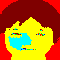

Learning rate:  0.00021599999999999996
Loss = tensor(1.4547, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4606, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  232


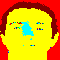

Learning rate:  0.00021599999999999996
Loss = tensor(1.4288, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4307, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4328, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4182, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4409, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  232


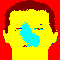

Learning rate:  0.00021599999999999996
Loss = tensor(1.4513, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4309, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4308, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4240, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4728, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  232


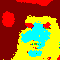

Learning rate:  0.00021599999999999996
Loss = tensor(1.4543, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4164, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  233


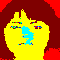

Learning rate:  0.00021599999999999996
Loss = tensor(1.4223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4626, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4183, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4566, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4113, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  233


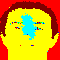

Learning rate:  0.00021599999999999996
Loss = tensor(1.4332, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4351, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4828, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4530, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  233


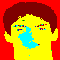

Learning rate:  0.00021599999999999996
Loss = tensor(1.4174, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4118, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  234


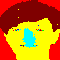

Learning rate:  0.00021599999999999996
Loss = tensor(1.4538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4348, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4376, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4639, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4407, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  234


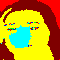

Learning rate:  0.00021599999999999996
Loss = tensor(1.4051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4487, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4702, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4390, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4436, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  234


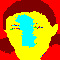

Learning rate:  0.00021599999999999996
Loss = tensor(1.4498, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4720, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  235


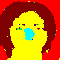

Learning rate:  0.00021599999999999996
Loss = tensor(1.4625, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4674, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4527, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4363, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4461, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  235


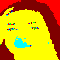

Learning rate:  0.00021599999999999996
Loss = tensor(1.4379, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4549, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4244, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4509, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4115, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  235


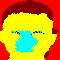

Learning rate:  0.00021599999999999996
Loss = tensor(1.4205, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4284, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  236


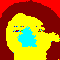

Learning rate:  0.00021599999999999996
Loss = tensor(1.4281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4480, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4589, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4258, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4466, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  236


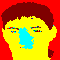

Learning rate:  0.00021599999999999996
Loss = tensor(1.4139, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4892, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4051, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4177, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4248, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  236


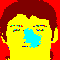

Learning rate:  0.00021599999999999996
Loss = tensor(1.4913, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4132, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  237


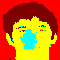

Learning rate:  0.00021599999999999996
Loss = tensor(1.4412, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4187, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4815, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4225, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  237


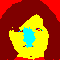

Learning rate:  0.00021599999999999996
Loss = tensor(1.4345, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4414, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4525, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4544, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  237


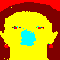

Learning rate:  0.00021599999999999996
Loss = tensor(1.4216, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4189, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  238


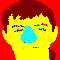

Learning rate:  0.00021599999999999996
Loss = tensor(1.4140, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4213, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4078, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4534, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4699, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  238


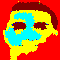

Learning rate:  0.00021599999999999996
Loss = tensor(1.4108, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4049, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4891, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4510, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  238


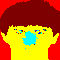

Learning rate:  0.00021599999999999996
Loss = tensor(1.4184, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4243, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  239


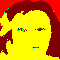

Learning rate:  0.00021599999999999996
Loss = tensor(1.4454, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4243, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4281, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4374, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4125, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  239


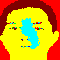

Learning rate:  0.00021599999999999996
Loss = tensor(1.4364, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4614, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4477, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4206, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4745, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  239


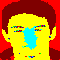

Learning rate:  0.00021599999999999996
Loss = tensor(1.4504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4318, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  240


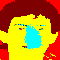

Learning rate:  0.00021599999999999996
Loss = tensor(1.4552, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4299, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4266, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4610, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4250, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  240


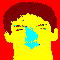

Learning rate:  0.00021599999999999996
Loss = tensor(1.4924, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4691, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4429, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4538, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4312, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  240


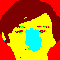

Learning rate:  0.00021599999999999996
Loss = tensor(1.4275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4685, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  241


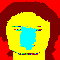

Learning rate:  0.00021599999999999996
Loss = tensor(1.4106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4172, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4042, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4457, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4545, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  241


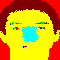

Learning rate:  0.00021599999999999996
Loss = tensor(1.4652, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4560, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4492, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4337, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  241


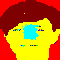

Learning rate:  0.00021599999999999996
Loss = tensor(1.4198, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4474, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  242


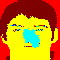

Learning rate:  0.00021599999999999996
Loss = tensor(1.4083, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4008, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4502, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4268, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4329, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  242


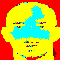

Learning rate:  0.00021599999999999996
Loss = tensor(1.4147, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4782, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4753, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4163, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4280, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  242


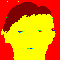

Learning rate:  0.00021599999999999996
Loss = tensor(1.4797, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4304, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  243


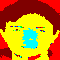

Learning rate:  0.00021599999999999996
Loss = tensor(1.4445, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4695, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4371, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4239, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4324, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  243


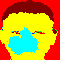

Learning rate:  0.00021599999999999996
Loss = tensor(1.4232, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4273, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4388, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4121, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  243


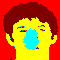

Learning rate:  0.00021599999999999996
Loss = tensor(1.4516, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4322, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  244


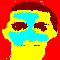

Learning rate:  0.00021599999999999996
Loss = tensor(1.4483, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4710, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4106, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4333, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4118, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  244


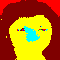

Learning rate:  0.00021599999999999996
Loss = tensor(1.4208, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4173, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4654, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4555, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4303, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  244


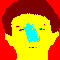

Learning rate:  0.00021599999999999996
Loss = tensor(1.4643, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4102, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  245


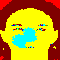

Learning rate:  0.00021599999999999996
Loss = tensor(1.4237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4475, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4693, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4368, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4214, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  245


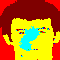

Learning rate:  0.00021599999999999996
Loss = tensor(1.4396, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4063, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4020, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4463, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4237, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  245


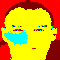

Learning rate:  0.00021599999999999996
Loss = tensor(1.4090, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4227, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  246


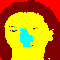

Learning rate:  0.00021599999999999996
Loss = tensor(1.4084, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4254, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4584, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4204, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  246


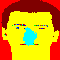

Learning rate:  0.00021599999999999996
Loss = tensor(1.4434, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4500, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4022, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4360, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4241, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  246


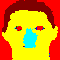

Learning rate:  0.00021599999999999996
Loss = tensor(1.4223, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4443, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  247


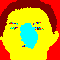

Learning rate:  0.00021599999999999996
Loss = tensor(1.4412, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4321, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4104, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4176, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  247


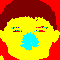

Learning rate:  0.00021599999999999996
Loss = tensor(1.4807, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4143, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4208, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4583, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4052, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  247


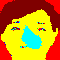

Learning rate:  0.00021599999999999996
Loss = tensor(1.4055, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4718, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  248


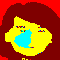

Learning rate:  0.00021599999999999996
Loss = tensor(1.4285, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4310, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4512, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4186, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4381, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  248


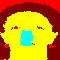

Learning rate:  0.00021599999999999996
Loss = tensor(1.4176, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4448, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4029, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4076, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4082, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  248


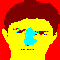

Learning rate:  0.00021599999999999996
Loss = tensor(1.4230, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4201, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  249


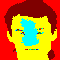

Learning rate:  0.00021599999999999996
Loss = tensor(1.4275, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4401, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4180, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4504, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4225, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  249


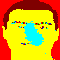

Learning rate:  0.00021599999999999996
Loss = tensor(1.3997, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4210, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4410, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4394, device='cuda:0', grad_fn=<NllLoss2DBackward>)
Loss = tensor(1.4234, device='cuda:0', grad_fn=<NllLoss2DBackward>)
EPOCH:  249


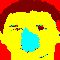

Learning rate:  0.00021599999999999996
Loss = tensor(1.4496, device='cuda:0', grad_fn=<NllLoss2DBackward>)


In [18]:
for epoch in range(epochs):
    i = 0
    last = False
    if epoch == epochs:
        last = True
    for batch in train_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)
            
        b = get_rgb(x)
        #out = loss1(b,c) + 4*loss1(b[3],c[3])+15*loss1(b[4],c[4])+4*loss1(b[5],c[5])
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_ce.append(float(out))
        c = b.detach().clone()
        
        if (i % 5 == 0):
            print("EPOCH: ", epoch)
            display(ts(max_rgb(c)[0]))
            print("Learning rate: ", scheduler.get_last_lr()[0])
            del c
        i += 1
        
        optimizer.zero_grad()
        out.backward()
        optimizer.step()
    scheduler.step()

In [19]:
torch.save(model, 'misc_figures/global.pth')

torch.Size([60, 60, 4])


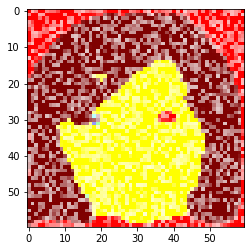

In [15]:
# Show certainty of pixels

a = max_rgba(b[0]).detach().clone().to('cpu')
plt.imshow(a.transpose(1,2).transpose(0,2))
plt.show()

In [39]:
# Save final iterations as gif

epoch_new = [ts(i) for i in epoch_history]
epoch_new[0].save('anitest.gif',
               save_all=True,
               append_images=epoch_new[1:],
               duration=1000,
               loop=0)

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score 
from sklearn.metrics import ConfusionMatrixDisplay

# DICE Score
def dice(pred, target, epsilon=1e-6):
    y_true_flatten = np.asarray(target.cpu()).astype(np.bool)
    y_pred_flatten = np.asarray(pred.cpu()).astype(np.bool)

    if not np.sum(y_true_flatten) + np.sum(y_pred_flatten):
        return 1.0

    return (2. * np.sum(y_true_flatten * y_pred_flatten)) /\
           (np.sum(y_true_flatten) + np.sum(y_pred_flatten) + epsilon)

# Precision, Recall, Accuracy and Specificity Score
def pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()

    x = confusion_matrix(pred, target)

    # Calculate FP, FN, TP, TN
    FP = x.sum(axis=0) - np.diag(x)
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d1[np.where(d1==0)] = -1
    d2 = TP+FN
    d2[np.where(d2==0)] = -1
    d3 = TP+TN+FP+FN
    d3[np.where(d3==0)] = -1
    d4 = TN+FP
    d4[np.where(d4==0)] = -1

    # Calculate and return scores
    precision = TP/d1
    recall = TP/d2
    accuracy = (TP+TN)/d3
    specificity = TN/d4
    
    return precision, recall, accuracy, specificity

# Recall Score
def overall_pras(pred, truth):
    
    # Convert to format for confusion matrix
    pred = pred.view(-1).cpu()
    target = truth.view(-1).cpu()
    
    x = confusion_matrix(pred, target)

    FP = x.sum(axis=0) - np.diag(x)  
    FN = x.sum(axis=1) - np.diag(x)
    TP = np.diag(x)
    TN = x.sum() - (FP + FN + TP)
    
    # Sum the values for overall values
    FP = np.sum(FP)
    FN = np.sum(FN)
    TP = np.sum(TP)
    TN = np.sum(TN)
    
    # Set the denominators and deal with 0 denominators
    d1 = TP+FP
    d2 = TP+FN
    d3 = TP+TN+FP+FN
    d4 = TN+FP
    
    # Calculate and return scores and deal with potential 0 denominators
    if d1 > 0:
        precision = TP/d1
    else:
        precision = -1
        
    if d2 > 0:
        recall = TP/d2
    else:
        recall = -1
    
    if d3 > 0:
        accuracy = (TP+TN)/d3
    else:
        d3 = -1
        
    if d4 > 0:
        specificity = TN/d4
    else:
        specificity = -1
    
    return precision, recall, accuracy, specificity

# Mutual Information
def mi(pred, target):
    print(pred.squeeze().shape)
    print(target.flatten().shape)
    return mutual_info_score(pred.flatten().cpu(), target.flatten().cpu())

def get_confusion(pred, target):
    pred = pred.view(-1).cpu()
    target = target.view(-1).cpu()
    x = confusion_matrix(pred.cpu(), target.cpu())
    return x

def print_confusion(conf):
    xt = ["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"]
    sns.set(font_scale=1.4, rc={'figure.figsize':(11.7,8.27)}) 
    sns.heatmap(conf, annot=True, annot_kws={"size": 16}, fmt='g', xticklabels=xt, yticklabels=xt)
    plt.savefig("confusion.png")

In [13]:
# Empty lists for precision, recall, accuracy, specificity, DICE

po_list = []
ro_list = []
ao_list = []
so_list = []

p_list = []
r_list = []
a_list = []
s_list = []

dice_list = []
mi_list = []

Loss = tensor(1.7118, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


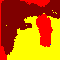

1.7117763757705688
Loss = tensor(1.5014, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


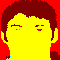

1.5013887882232666
Loss = tensor(1.4528, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


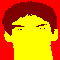

1.452806830406189
Loss = tensor(1.5163, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


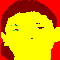

1.5162779092788696
Loss = tensor(1.4939, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


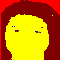

1.4939030408859253
Loss = tensor(1.4518, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


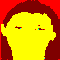

1.4517555236816406
Loss = tensor(1.4702, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


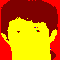

1.4702038764953613
Loss = tensor(1.4840, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


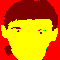

1.4839794635772705
Loss = tensor(1.5081, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


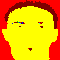

1.5080593824386597
Loss = tensor(1.5539, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


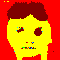

1.5539296865463257
Loss = tensor(1.4593, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


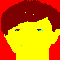

1.4593110084533691
Loss = tensor(1.5114, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


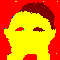

1.5114126205444336
Loss = tensor(1.4688, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


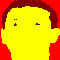

1.4687875509262085
Loss = tensor(1.4956, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


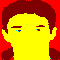

1.495639681816101
Loss = tensor(1.4771, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


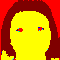

1.4771076440811157
Loss = tensor(1.4384, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


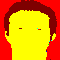

1.438395380973816
Loss = tensor(1.5227, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


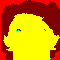

1.5227168798446655
Loss = tensor(1.5446, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


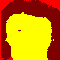

1.5446181297302246
Loss = tensor(1.4738, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


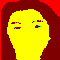

1.4737904071807861
Loss = tensor(1.4804, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


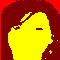

1.4803895950317383
Loss = tensor(1.4680, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


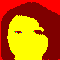

1.4679539203643799
Loss = tensor(1.5180, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


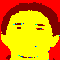

1.5180424451828003
Loss = tensor(1.4816, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


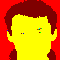

1.48159921169281
Loss = tensor(1.5637, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


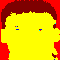

1.5637059211730957
Loss = tensor(1.4621, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


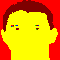

1.4621357917785645
Loss = tensor(1.4437, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


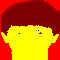

1.4436614513397217
Loss = tensor(1.4616, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


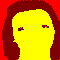

1.4615554809570312
Loss = tensor(1.4846, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


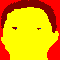

1.4845584630966187
Loss = tensor(1.4792, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


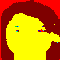

1.4791767597198486
Loss = tensor(1.4657, device='cuda:0')
torch.Size([60, 60])
torch.Size([3600])


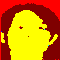

1.4656665325164795


In [14]:
# Inference and test loss
loss_test_ce = []
batch_size=1
conf_running = torch.zeros(6,6)

with torch.no_grad():
    for batch in test_loader_CE:
        inputs, targets = batch
        if last == True:
            x, epoch_history = model.forward(130, inputs, last=last)
        else:
            x = model.forward(130, inputs, last=last)

        b = get_rgb(x)
        pred = torch.argmax(b, dim=1)
        out = loss2(b, targets.detach().long())
        print("Loss =", out)
        loss_test_ce.append(float(out))
        c = b.detach().clone()
        
        target = targets.detach().long()
        
        # Log metrics
        p,r,a,s = overall_pras(pred, target)
        po_list.append(p)
        ro_list.append(r)
        ao_list.append(a)
        so_list.append(s)
        
        d = dice(pred, target)
        dice_list.append(d.item())
        
        m = mi(pred, target)
        mi_list.append(m)
        
        p,r,a,s = pras(pred, target)
        p_list.append(p)
        r_list.append(r)
        a_list.append(a)
        s_list.append(s)
        
        conf_running += get_confusion(pred, target)
        
        for i in range(batch_size):
            display(ts(max_rgb(c)[i]))
        del c
        print(float(out))

In [16]:
boxplot_p = np.array(p_list)
boxplot_r = np.array(r_list)
boxplot_a = np.array(a_list)
boxplot_s = np.array(s_list)
boxplot_mi = np.array(mi_list)

np.save('metrics/global_p.npy', boxplot_p)
np.save('metrics/global_r.npy', boxplot_r)
np.save('metrics/global_a.npy', boxplot_a)
np.save('metrics/global_s.npy', boxplot_s)
np.save('metrics/global_m.npy', boxplot_mi)
np.save('metrics/global_dice.npy', dice_list)

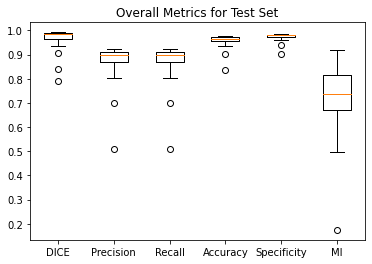

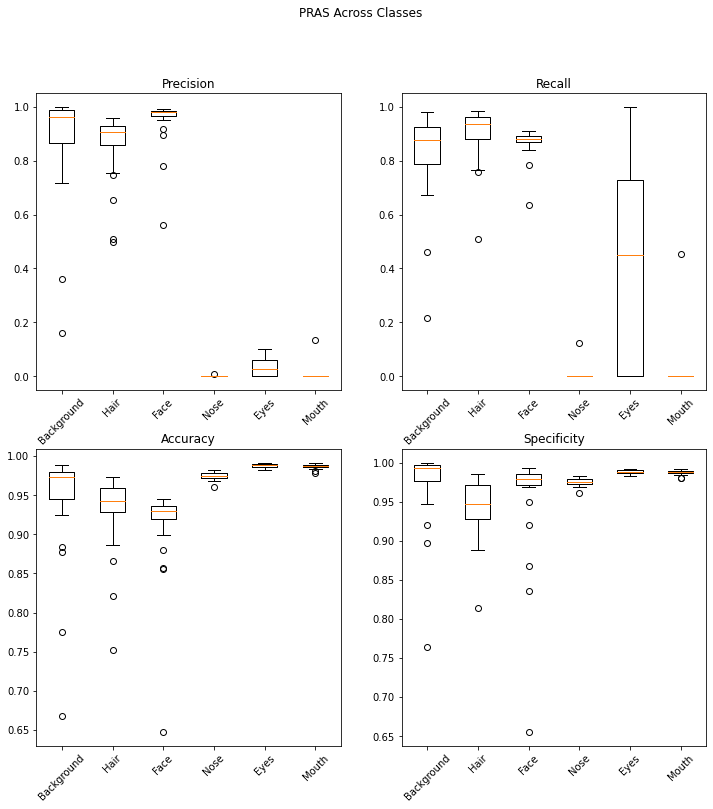

In [17]:
pras_overall_list = [dice_list, po_list, ro_list, ao_list, so_list, mi_list]
#sns.boxplot(x=np.array(pras_overall_list), y=np.array([1,2,3,4]))
plt.boxplot(pras_overall_list)
plt.xticks([1,2,3,4,5,6],["DICE", "Precision", "Recall", "Accuracy", "Specificity", "MI"])
plt.title("Overall Metrics for Test Set")
plt.savefig("1GlobalPras.png")


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
ax1.boxplot(boxplot_p)
ax1.set_title("Precision")
ax1.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax2.boxplot(boxplot_r)
ax2.set_title("Recall")
ax2.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax3.boxplot(boxplot_a)
ax3.set_title("Accuracy")
ax3.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

ax4.boxplot(boxplot_s)
ax4.set_title("Specificity")
ax4.set_xticklabels(["Background", "Hair", "Face", "Nose", "Eyes", "Mouth"])

fig.set_figwidth(12)
fig.set_figheight(12)

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
fig.suptitle('PRAS Across Classes')

plt.savefig("pras/1GlobalPrasClass.png")

In [30]:
np.save('dice_global.npy', dice_list)